In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
import random

In [87]:
# Connect to an R session
import rpy2.robjects
r = rpy2.robjects.r
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
from rpy2.robjects.environments import Environment
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
#Specify path with downloaded R packages
lib_path = 'C:/Users/BUCKBEAK/Documents/BUCKBEAK/R/win-library/3.2'

# load some required packages
utils = importr('utils')
langR = importr('languageR', lib_loc=lib_path)
lme4 = importr('lme4', lib_path)
lmerTest=importr('lmerTest', lib_path)
mass = importr('MASS', lib_path)
packages = importr('packages', lib_path)

RRuntimeError: Error in loadNamespace(name) : there is no package called 'packages'


#Bring in all datasets from regressions

In [3]:
#7 days weighted
df = pd.read_csv('final_race_df_7daysweighted.csv')
df2 = pd.read_csv('workout_final_race_df_7daysweighted.csv')
weight_regdf7 = pd.merge(df, df2, how='left')
weight_regdf7 = weight_regdf7.drop(df.columns[0], axis=1)

#6 days weighted
df = pd.read_csv('final_race_df_6daysweighted.csv')
df2 = pd.read_csv('workout_final_race_df_6daysweighted.csv')
weight_regdf6 = pd.merge(df, df2, how='left')
weight_regdf6 = weight_regdf6.drop(df.columns[0], axis=1)

#5 days weighted
df = pd.read_csv('final_race_df_5daysweighted.csv')
df2 = pd.read_csv('workout_final_race_df_5daysweighted.csv')
weight_regdf5 = pd.merge(df, df2, how='left')
weight_regdf5 = weight_regdf5.drop(df.columns[0], axis=1)

#4 days weighted
df = pd.read_csv('final_race_df_4daysweighted.csv')
df2 = pd.read_csv('workout_final_race_df_4daysweighted.csv')
weight_regdf4 = pd.merge(df, df2, how='left')
weight_regdf4 = weight_regdf4.drop(df.columns[0], axis=1)

#3 days weighted
df = pd.read_csv('final_race_df_3daysweighted.csv')
df2 = pd.read_csv('workout_final_race_df_3daysweighted.csv')
weight_regdf3 = pd.merge(df, df2, how='left')
weight_regdf3 = weight_regdf3.drop(df.columns[0], axis=1)

#2 days weighted
df = pd.read_csv('final_race_df_2daysweighted.csv')
df2 = pd.read_csv('workout_final_race_df_2daysweighted.csv')
weight_regdf2 = pd.merge(df, df2, how='left')
weight_regdf2 = weight_regdf2.drop(df.columns[0], axis=1)

#DataFrames for the 5 individual days before the race
df = pd.read_csv('race_df_pre_weighting.csv')
dummies = pd.get_dummies(df['user_id'], prefix='user')
temp_df = pd.concat([df, dummies], axis=1)
race_times = pd.read_csv('huxc_race_times.csv')
race_times=race_times[race_times['user_id']!=2461]
race_times=race_times[race_times['user_id']!=2509]
reg_df = temp_df.merge(race_times, how='left')
reg_df = reg_df[reg_df['user_id']!=2439]
reg_df = reg_df.drop(['user_828'], axis=1)
reg_df = reg_df.drop(df.columns[0], axis=1).reset_index(drop=True)

reg_df0 = reg_df[reg_df['buildup_days']==0].reset_index(drop=True)
reg_df1 = reg_df[reg_df['buildup_days']==1].reset_index(drop=True)
reg_df2 = reg_df[reg_df['buildup_days']==2].reset_index(drop=True)
reg_df3 = reg_df[reg_df['buildup_days']==3].reset_index(drop=True)
reg_df4 = reg_df[reg_df['buildup_days']==4].reset_index(drop=True)
reg_df5 = reg_df[reg_df['buildup_days']==5].reset_index(drop=True)

#Exponentially Weighted DataFrames
rec_weight_df5 = pd.read_csv('expo_final_race_df_5daysweighted.csv')
wkout_weight_df5 = pd.read_csv('expo_workout_final_race_df_5daysweighted.csv')
expo_weight_df5 = pd.merge(rec_weight_df5, wkout_weight_df5, how='left')
expo_weight_df5 = expo_weight_df5.drop(df.columns[0], axis=1)

rec_weight_df4 = pd.read_csv('expo_final_race_df_4daysweighted.csv')
wkout_weight_df4 = pd.read_csv('expo_workout_final_race_df_4daysweighted.csv')
expo_weight_df4 = pd.merge(rec_weight_df4, wkout_weight_df4, how='left')
expo_weight_df4 = expo_weight_df4.drop(df.columns[0], axis=1)

rec_weight_df3 = pd.read_csv('expo_final_race_df_3daysweighted.csv')
wkout_weight_df3 = pd.read_csv('expo_workout_final_race_df_3daysweighted.csv')
expo_weight_df3 = pd.merge(rec_weight_df3, wkout_weight_df3, how='left')
expo_weight_df3 = expo_weight_df3.drop(df.columns[0], axis=1)

rec_weight_df2 = pd.read_csv('expo_final_race_df_2daysweighted.csv')
wkout_weight_df2 = pd.read_csv('expo_workout_final_race_df_2daysweighted.csv')
expo_weight_df2 = pd.merge(rec_weight_df2, wkout_weight_df2, how='left')
expo_weight_df2 = expo_weight_df2.drop(df.columns[0], axis=1)

def rescale_race_pace(df):
    #mean-centering pace per kilometer
    mean_df = df.groupby('user_id').mean().reset_index()
    mean_df = mean_df[['user_id', 'pace_per_k']]
    mean_df.rename(columns={'pace_per_k':'pace_per_k_mean'}, inplace=True)
    df = df.merge(mean_df, how="left")
    
    #rescale other variables
    df['rem_sleep_duration']=df['rem_sleep_duration'].div(60000.0)
    df['sleep_duration']=df['sleep_duration'].div(60000.0)
    df['slow_wave_sleep_duration']=df['slow_wave_sleep_duration'].div(60000.0)
    df['light_sleep_duration']=df['light_sleep_duration'].div(60000.0)
    df['latency']=df['latency'].div(60000.0)
    df['time_in_bed']=df['time_in_bed'].div(60000.0)
    return df

def rescale_df(df, weighted=False):
    #mean-centering pace per kilometer
    mean_df = df.groupby('user_id').mean().reset_index()
    mean_df = mean_df.drop(['race_period', 'user_2456', 'user_2458', 'user_2465', 'user_2466', 'user_2473', 'user_2508', 'user_2439', 
                            'user_2469', 'user_2468', 'FP_5K', 'Wisco_8K', 'Brown_8K', 'VCP_8K_Heps', 'FP_10K', 'VCP_8K_IC4A'], axis=1)
    mean_df.rename(columns=lambda x: x+'_mean', inplace=True)
    mean_df.rename(columns={'user_id_mean':'user_id'}, inplace=True)
    df = df.merge(mean_df, how="left")
    
    
    #now mean-center everything else
    df.rename(columns={'hrv_rmssd': 'hrv_rmssd_x', 'resting_heart_rate': 'resting_heart_rate_x', 'time_in_bed':'time_in_bed_x',
                      'latency':'latency_x', 'rem_sleep_duration':'rem_sleep_duration_x', 'slow_wave_sleep_duration':'slow_wave_sleep_duration_x',
                      'light_sleep_duration':'light_sleep_duration_x','sleep_duration':'sleep_duration_x', 'wake_duration':'wake_duration_x', 'cycles_count':'cycles_count_x',
                      'score':'score_x', 'recovery_score':'recovery_score_x', 'seconds':'seconds_x', 'pace_per_k':'pace_per_k_x'}, inplace=True)
    cols = ['hrv_rmssd', 'resting_heart_rate', 'time_in_bed', 'latency', 'rem_sleep_duration', 'slow_wave_sleep_duration', 
           'light_sleep_duration', 'sleep_duration', 'wake_duration', 'cycles_count', 'score', 'recovery_score', 'seconds', 'pace_per_k']
    for c in cols:
        df[c]=df[c+'_x'] - df[c+'_mean']
        df = df.drop([c+'_x', c+'_mean'], axis=1)
    
    if weighted==True:
        df.rename(columns={'z1':'z1_x', 'z2':'z2_x','z3':'z3_x', 'z4':'z4_x','z5':'z5_x'}, inplace=True)
        cols = ['z1', 'z2', 'z3', 'z4', 'z5']
        for c in cols:
            df[c]=df[c+'_x'] - df[c+'_mean']
            df = df.drop([c+'_x', c+'_mean'], axis=1)
            
    #rescale other variables
    df['rem_sleep_duration']=df['rem_sleep_duration'].div(60000.0)
    df['sleep_duration']=df['sleep_duration'].div(60000.0)
    df['slow_wave_sleep_duration']=df['slow_wave_sleep_duration'].div(60000.0)
    df['light_sleep_duration']=df['light_sleep_duration'].div(60000.0)
    df['latency']=df['latency'].div(60000.0)
    df['time_in_bed']=df['time_in_bed'].div(60000.0)
    
    return df

reg_df0_mc = rescale_df(reg_df0)
reg_df1_mc = rescale_df(reg_df1)
reg_df2_mc = rescale_df(reg_df2)
reg_df3_mc = rescale_df(reg_df3)

weight_regdf2_mc = rescale_df(weight_regdf2)
weight_regdf3_mc = rescale_df(weight_regdf3)
weight_regdf4_mc = rescale_df(weight_regdf4)
weight_regdf5_mc = rescale_df(weight_regdf5)
weight_regdf6_mc = rescale_df(weight_regdf6)
weight_regdf7_mc = rescale_df(weight_regdf7)

expo_weight_df2_mc = rescale_df(expo_weight_df2)
expo_weight_df3_mc = rescale_df(expo_weight_df3)
expo_weight_df4_mc = rescale_df(expo_weight_df4)
expo_weight_df5_mc = rescale_df(expo_weight_df5)

#convert to R
r_reg_df0_mc = pandas2ri.py2ri(reg_df0_mc)
r_reg_df1_mc = pandas2ri.py2ri(reg_df1_mc)
r_reg_df2_mc = pandas2ri.py2ri(reg_df2_mc)
r_reg_df3_mc = pandas2ri.py2ri(reg_df3_mc)
r_weight_df2_mc = pandas2ri.py2ri(weight_regdf2_mc)
r_weight_df3_mc = pandas2ri.py2ri(weight_regdf3_mc)
r_weight_df4_mc = pandas2ri.py2ri(weight_regdf4_mc)
r_weight_df5_mc = pandas2ri.py2ri(weight_regdf5_mc)
r_weight_df6_mc = pandas2ri.py2ri(weight_regdf6_mc)
r_weight_df7_mc = pandas2ri.py2ri(weight_regdf7_mc)
r_expo_weight_df2_mc = pandas2ri.py2ri(expo_weight_df2_mc)
r_expo_weight_df3_mc = pandas2ri.py2ri(expo_weight_df3_mc)
r_expo_weight_df4_mc = pandas2ri.py2ri(expo_weight_df4_mc)
r_expo_weight_df5_mc = pandas2ri.py2ri(expo_weight_df5_mc)


In [4]:
#df.head()

In [5]:
#final_df.head()

In [6]:
#reg_df1.head()

Then grabbing variables that were significant, and put into one dataframe

###Varying Intercept Only
####For Races
- REM sleep, runner mixed effects, two nights before the race: significant for both Bonferroni and Permutation Correction
- REM sleep, runner mixed effects, weighted two days: significant for Bonferroni only
- REM sleep, runner mixed effects, weighted three days: significant for Bonferroni only
- Total sleep, runner mixed effects, weighted three days: significant for Bonerroni only
- REM sleep, runner mixed effects, weighted four days: significant for Bonerroni only
- REM sleep, runner mixed effects, expo weighted 2 days: significant for both Bonferroni and Permutation Correction

####For Bike Efforts
- Slow wave sleep, runner mixed effects, 2nd night before the bike: significant for Bonferroni

###Varying Slope and Intercept

####For Races
- REM cycle count, runner mixed effects, two nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted two nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted three nights before the race: significant for Bonferroni
- REM cycle count, runner mixed effects, weighted three nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted four nights before the race: significant for Bonferroni
- REM cycle count, runner mixed effects, weighted four nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted five nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted six nights before the race: significant for Bonferroni
- REM sleep duration, runner mixed effects, exponentially weighted two nights before the race, significant for Bonferroni
- REM sleep duration, runner mixed effects, exponentially weighted three nights before the race, singificant for Bonferroni
- REM sleep duration, runner mixed effects, exponentially weighted four nights before the race, significant for Bonferroni

In [7]:
REM_2nd_Night_Before = reg_df1[['user_id', 'race_period', 'rem_sleep_duration']]
REM_Weighted_Two_Days = weight_regdf2[['user_id', 'race_period', 'rem_sleep_duration']]
REM_Weighted_Three_Days = weight_regdf3[['user_id', 'race_period', 'rem_sleep_duration']]
REM_Weighted_Four_Days = weight_regdf4[['user_id', 'race_period', 'rem_sleep_duration']]
REM_Expo_Weighted_Two_Days = expo_weight_df2[['user_id', 'race_period', 'rem_sleep_duration']]
total_sleep_weighted_3days = weight_regdf3[['user_id', 'race_period', 'sleep_duration']]

cycles_count_2nd_Night_Before = reg_df1[['user_id', 'race_period', 'cycles_count']]
cycles_count_weighted_3days = weight_regdf3[['user_id', 'race_period', 'cycles_count']]
cycles_count_weighted_4days = weight_regdf4[['user_id', 'race_period', 'cycles_count']]
total_sleep_weighted_2days = weight_regdf2[['user_id', 'race_period', 'sleep_duration']]
total_sleep_weighted_4days = weight_regdf4[['user_id', 'race_period', 'sleep_duration']]
total_sleep_weighted_5days = weight_regdf5[['user_id', 'race_period', 'sleep_duration']]
total_sleep_weighted_6days = weight_regdf6[['user_id', 'race_period', 'sleep_duration']]
REM_Expo_Weighted_3days = expo_weight_df3[['user_id', 'race_period', 'rem_sleep_duration']]
REM_Expo_Weighted_4days = expo_weight_df4[['user_id', 'race_period', 'rem_sleep_duration']]

#convert to R
#pandas2ri.activate()
#R_REM_2nd_Night_Before = pandas2ri.py2ri(REM_2nd_Night_Before)
#R_REM_Weighted_Two_Days = pandas2ri.py2ri(REM_Weighted_Two_Days)
#R_REM_Weighted_Three_Days = pandas2ri.py2ri(REM_Weighted_Three_Days)
#R_REM_Weighted_Four_Days = pandas2ri.py2ri(REM_Weighted_Four_Days)
#R_REM_Expo_Weighted_Two_Days = pandas2ri.py2ri(REM_Expo_Weighted_Two_Days)
#R_total_sleep_weighted_3days = pandas2ri.py2ri(total_sleep_weighted_3days)

#R_cycles_count_2nd_Night_Before = pandas2ri.py2ri(cycles_count_2nd_Night_Before)
#R_cycles_count_weighted_3days = pandas2ri.py2ri(cycles_count_weighted_3days)
#R_cycles_count_weighted_4days = pandas2ri.py2ri(cycles_count_weighted_4days)
#R_total_sleep_weighted_2days = pandas2ri.py2ri(total_sleep_weighted_2days)
#R_total_sleep_weighted_4days = pandas2ri.py2ri(total_sleep_weighted_4days)
#R_total_sleep_weighted_5days = pandas2ri.py2ri(total_sleep_weighted_5days)
#R_total_sleep_weighted_6days = pandas2ri.py2ri(total_sleep_weighted_6days)
#R_REM_Expo_Weighted_3days = pandas2ri.py2ri(REM_Expo_Weighted_3days)
#R_REM_Expo_Weighted_4days = pandas2ri.py2ri(REM_Expo_Weighted_4days)





In [8]:
cycles_count_2nd_Night_Before.head()

,user_id,race_period,cycles_count
0,828,1,10
1,828,2,2
2,828,3,2
3,828,4,7
4,828,5,NaN


In [9]:
df = reg_df0
df = reg_df0.drop(['date_md', 'start', 'end', 'score', 'latency', 'time_in_bed', 'wake_duration', 'light_sleep_duration', 
                  'slow_wave_sleep_duration', 'rem_sleep_duration', 'debt_post', 'is_nap', 'recovery_score', 'cycles_count',
                  'resting_heart_rate', 'hrv_rmssd', 'end_epoch', 'buildup_days', 'sleep_duration', 'disturbances'], axis=1)
#merge in variables of interest
df = df.merge(REM_2nd_Night_Before, how="left")
df.rename(columns = {'rem_sleep_duration':'REM_2nd_Night_Before'}, inplace = True)
df = df.merge(REM_Weighted_Two_Days, how="left")
df.rename(columns = {'rem_sleep_duration':'REM_Weighted_2_Days'}, inplace = True)
df = df.merge(REM_Weighted_Three_Days, how="left")
df.rename(columns = {'rem_sleep_duration':'REM_Weighted_3_Days'}, inplace = True)
df = df.merge(REM_Weighted_Four_Days, how="left")
df.rename(columns = {'rem_sleep_duration':'REM_Weighted_4_Days'}, inplace = True)
df = df.merge(REM_Expo_Weighted_Two_Days, how="left")
df.rename(columns = {'rem_sleep_duration':'REM_Expo_Weighted_2_Days'}, inplace = True)
df = df.merge(total_sleep_weighted_3days, how="left")
df.rename(columns = {'sleep_duration':'total_sleep_weighted_3days'}, inplace = True)

df = df.merge(cycles_count_2nd_Night_Before, how="left")
df.rename(columns = {'cycles_count':'cycles_count_2nd_Night_Before'}, inplace = True)
df = df.merge(cycles_count_weighted_3days, how="left")
df.rename(columns = {'cycles_count':'cycles_count_weighted_3days'}, inplace = True)
df = df.merge(cycles_count_weighted_4days, how="left")
df.rename(columns = {'cycles_count':'cycles_count_weighted_4days'}, inplace = True)
df = df.merge(total_sleep_weighted_2days, how="left")
df.rename(columns = {'sleep_duration':'total_sleep_weighted_2days'}, inplace = True)
df = df.merge(total_sleep_weighted_4days, how="left")
df.rename(columns = {'sleep_duration':'total_sleep_weighted_4days'}, inplace = True)
df = df.merge(total_sleep_weighted_5days, how="left")
df.rename(columns = {'sleep_duration':'total_sleep_weighted_5days'}, inplace = True)
df = df.merge(total_sleep_weighted_6days, how="left")
df.rename(columns = {'sleep_duration':'total_sleep_weighted_6days'}, inplace = True)
df = df.merge(REM_Expo_Weighted_3days, how="left")
df.rename(columns = {'rem_sleep_duration':'REM_Expo_Weighted_3days'}, inplace = True)
df = df.merge(REM_Expo_Weighted_4days, how="left")
df.rename(columns = {'rem_sleep_duration':'REM_Expo_Weighted_4days'}, inplace = True)

df.head()

,user_id,race_period,race_course,user_2439,user_2456,user_2458,user_2465,user_2466,user_2468,user_2469,user_2473,user_2508,seconds,pace_per_k,pace_time,FP_5K,Wisco_8K,Brown_8K,VCP_8K_Heps,FP_10K,VCP_8K_IC4A,REM_2nd_Night_Before,REM_Weighted_2_Days,REM_Weighted_3_Days,REM_Weighted_4_Days,REM_Expo_Weighted_2_Days,total_sleep_weighted_3days,cycles_count_2nd_Night_Before,cycles_count_weighted_3days,cycles_count_weighted_4days,total_sleep_weighted_2days,total_sleep_weighted_4days,total_sleep_weighted_5days,total_sleep_weighted_6days,REM_Expo_Weighted_3days,REM_Expo_Weighted_4days
0,828,1,FP_8K,0,0,0,0,0,0,0,0,0,1529.2,191.1500,03:11.1,0,0,0,0,0,0,5310000,4680000,4737000,5002000,5364000,31014000,10,7.7,7.666667,30850000,30946000,30625714.2857,29360357.1429,4983157.895,6390000.00000
1,828,2,Brown_8K,0,0,0,0,0,0,0,0,0,1552.3,194.0375,03:14.0,0,0,1,0,0,0,1230000,1980000,2457000,2938000,744000,29592000,2,4.1,4.400000,29465000,29660000,29694000.0000,29561538.4615,4200000.000,5284153.84615
2,828,3,VCP_8K_Heps,0,0,0,0,0,0,0,0,0,1582.5,197.8125,03:17.8,0,0,0,1,0,0,600000,1305000,1389000,1356000,492000,27933000,2,3.0,2.933333,27735000,28218000,28360500.0000,28440000.0000,1665789.474,1135846.15385
3,828,4,FP_10K,0,0,0,0,0,0,0,0,0,1932.7,193.2700,03:13.3,0,0,0,0,1,0,2580000,4350000,4620000,4488000,8466000,35817000,7,9.3,9.000000,35880000,35390000,34745714.2857,34243928.5714,5535789.474,3660000.00000
4,828,5,VCP_8K_IC4A,0,0,0,0,0,0,0,0,0,1617.6,202.2000,03:22.2,0,0,0,0,0,1,NaN,NaN,2010000,2420000,NaN,28800000,NaN,3.0,4.666667,NaN,30140000,30370000.0000,29991000.0000,2010000.000,2748000.00000


In [10]:
#add in average stress and survey data
stress_data = pd.read_csv('survey_data.csv')
schwk_data = pd.read_csv('schoolwork_data.csv')
stress_data = stress_data[stress_data['user_id']!=2439]
schwk_data = schwk_data[schwk_data['user_id']!=2439]
df = df.merge(stress_data, how="left")
df = df.drop(['2nd_week_stress', 'avg_stress'], axis=1)
df = df.merge(schwk_data, how="left")
df = df.drop(['schoolwork_hrs_2nd_week'], axis=1)
df.rename(columns = {'1st_week_stress':'stress_during_week', 'schoolwork_hrs_1week':'schoolwork_hours_during_week'}, inplace=True)

In [11]:
df['stress_during_week_2']=df['stress_during_week']
df.head()

,user_id,race_period,race_course,user_2439,user_2456,user_2458,user_2465,user_2466,user_2468,user_2469,user_2473,user_2508,seconds,pace_per_k,pace_time,FP_5K,Wisco_8K,Brown_8K,VCP_8K_Heps,FP_10K,VCP_8K_IC4A,REM_2nd_Night_Before,REM_Weighted_2_Days,REM_Weighted_3_Days,REM_Weighted_4_Days,REM_Expo_Weighted_2_Days,total_sleep_weighted_3days,cycles_count_2nd_Night_Before,cycles_count_weighted_3days,cycles_count_weighted_4days,total_sleep_weighted_2days,total_sleep_weighted_4days,total_sleep_weighted_5days,total_sleep_weighted_6days,REM_Expo_Weighted_3days,REM_Expo_Weighted_4days,stress_during_week,schoolwork_hours_during_week,stress_during_week_2
0,828,1,FP_8K,0,0,0,0,0,0,0,0,0,1529.2,191.1500,03:11.1,0,0,0,0,0,0,5310000,4680000,4737000,5002000,5364000,31014000,10,7.7,7.666667,30850000,30946000,30625714.2857,29360357.1429,4983157.895,6390000.00000,NaN,NaN,NaN
1,828,2,Brown_8K,0,0,0,0,0,0,0,0,0,1552.3,194.0375,03:14.0,0,0,1,0,0,0,1230000,1980000,2457000,2938000,744000,29592000,2,4.1,4.400000,29465000,29660000,29694000.0000,29561538.4615,4200000.000,5284153.84615,4,14,4
2,828,3,VCP_8K_Heps,0,0,0,0,0,0,0,0,0,1582.5,197.8125,03:17.8,0,0,0,1,0,0,600000,1305000,1389000,1356000,492000,27933000,2,3.0,2.933333,27735000,28218000,28360500.0000,28440000.0000,1665789.474,1135846.15385,2,6,2
3,828,4,FP_10K,0,0,0,0,0,0,0,0,0,1932.7,193.2700,03:13.3,0,0,0,0,1,0,2580000,4350000,4620000,4488000,8466000,35817000,7,9.3,9.000000,35880000,35390000,34745714.2857,34243928.5714,5535789.474,3660000.00000,3,8,3
4,828,5,VCP_8K_IC4A,0,0,0,0,0,0,0,0,0,1617.6,202.2000,03:22.2,0,0,0,0,0,1,NaN,NaN,2010000,2420000,NaN,28800000,NaN,3.0,4.666667,NaN,30140000,30370000.0000,29991000.0000,2010000.000,2748000.00000,3,NaN,3


In [12]:
df.stress_during_week_2[df['stress_during_week_2'] >= 4]=5
df.stress_during_week_2[df['stress_during_week_2'] == 3]=2.5
df.stress_during_week_2[df['stress_during_week_2'] == 2]=2.5
df.stress_during_week_2[df['stress_during_week_2'] == 1]=0

C:\Users\BUCKBEAK\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\BUCKBEAK\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\BUCKBEAK\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\BUCKB

In [13]:
df.columns

Index([u'user_id', u'race_period', u'race_course', u'user_2439', u'user_2456', u'user_2458', u'user_2465', u'user_2466', u'user_2468', u'user_2469', u'user_2473', u'user_2508', u'seconds', u'pace_per_k', u'pace_time', u'FP_5K', u'Wisco_8K', u'Brown_8K', u'VCP_8K_Heps', u'FP_10K', u'VCP_8K_IC4A', u'REM_2nd_Night_Before', u'REM_Weighted_2_Days', u'REM_Weighted_3_Days', u'REM_Weighted_4_Days', u'REM_Expo_Weighted_2_Days', u'total_sleep_weighted_3days', u'cycles_count_2nd_Night_Before',
       u'cycles_count_weighted_3days', u'cycles_count_weighted_4days', u'total_sleep_weighted_2days', u'total_sleep_weighted_4days', u'total_sleep_weighted_5days', u'total_sleep_weighted_6days', u'REM_Expo_Weighted_3days', u'REM_Expo_Weighted_4days', u'stress_during_week', u'schoolwork_hours_during_week', u'stress_during_week_2'],
      dtype='object')

In [14]:
#For plotting later
df_pre = df
df_pre['REM_2nd_Night_Before']=df_pre['REM_2nd_Night_Before'].div(60000.0)
df_pre['REM_Weighted_2_Days']=df_pre['REM_Weighted_2_Days'].div(60000.0)
df_pre['REM_Weighted_3_Days']=df_pre['REM_Weighted_3_Days'].div(60000.0)
df_pre['REM_Weighted_4_Days']=df_pre['REM_Weighted_4_Days'].div(60000.0)
df_pre['REM_Expo_Weighted_2_Days']=df_pre['REM_Expo_Weighted_2_Days'].div(60000.0)
df_pre['total_sleep_weighted_3days']=df_pre['total_sleep_weighted_3days'].div(60000.0)

df_pre['total_sleep_weighted_2days']=df_pre['total_sleep_weighted_2days'].div(60000.0)
df_pre['total_sleep_weighted_4days']=df_pre['total_sleep_weighted_4days'].div(60000.0)
df_pre['total_sleep_weighted_5days']=df_pre['total_sleep_weighted_5days'].div(60000.0)
df_pre['total_sleep_weighted_6days']=df_pre['total_sleep_weighted_6days'].div(60000.0)
df_pre['REM_Expo_Weighted_3days']=df_pre['REM_Expo_Weighted_3days'].div(60000.0)
df_pre['REM_Expo_Weighted_4days']=df_pre['REM_Expo_Weighted_4days'].div(60000.0)



In [15]:
df.columns

Index([u'user_id', u'race_period', u'race_course', u'user_2439', u'user_2456', u'user_2458', u'user_2465', u'user_2466', u'user_2468', u'user_2469', u'user_2473', u'user_2508', u'seconds', u'pace_per_k', u'pace_time', u'FP_5K', u'Wisco_8K', u'Brown_8K', u'VCP_8K_Heps', u'FP_10K', u'VCP_8K_IC4A', u'REM_2nd_Night_Before', u'REM_Weighted_2_Days', u'REM_Weighted_3_Days', u'REM_Weighted_4_Days', u'REM_Expo_Weighted_2_Days', u'total_sleep_weighted_3days', u'cycles_count_2nd_Night_Before',
       u'cycles_count_weighted_3days', u'cycles_count_weighted_4days', u'total_sleep_weighted_2days', u'total_sleep_weighted_4days', u'total_sleep_weighted_5days', u'total_sleep_weighted_6days', u'REM_Expo_Weighted_3days', u'REM_Expo_Weighted_4days', u'stress_during_week', u'schoolwork_hours_during_week', u'stress_during_week_2'],
      dtype='object')

In [16]:
def mean_center_and_convert_column(df, col_name):
    mean_df = df.groupby('user_id').mean().reset_index()
    mean_df.rename(columns={col_name: col_name+'_mean'}, inplace=True)
    mean_df = mean_df[['user_id', col_name+'_mean']]
    new_df = df.merge(mean_df, how="left")
    new_df.rename(columns={col_name:col_name+'_x'}, inplace=True)
    new_df[col_name] = new_df[col_name+'_x'] - new_df[col_name+'_mean']
    if (col_name == 'cycles_count'):
        return new_df
    elif (col_name == 'cycles_count_2nd_Night_Before'):
        return new_df
    elif (col_name == 'cycles_count_weighted_3days'):
        return new_df
    elif (col_name != 'cycles_count_weighted_4days'):
        return new_df
    else:
        return new_df
    return new_df

In [17]:
df.head()

,user_id,race_period,race_course,user_2439,user_2456,user_2458,user_2465,user_2466,user_2468,user_2469,user_2473,user_2508,seconds,pace_per_k,pace_time,FP_5K,Wisco_8K,Brown_8K,VCP_8K_Heps,FP_10K,VCP_8K_IC4A,REM_2nd_Night_Before,REM_Weighted_2_Days,REM_Weighted_3_Days,REM_Weighted_4_Days,REM_Expo_Weighted_2_Days,total_sleep_weighted_3days,cycles_count_2nd_Night_Before,cycles_count_weighted_3days,cycles_count_weighted_4days,total_sleep_weighted_2days,total_sleep_weighted_4days,total_sleep_weighted_5days,total_sleep_weighted_6days,REM_Expo_Weighted_3days,REM_Expo_Weighted_4days,stress_during_week,schoolwork_hours_during_week,stress_during_week_2
0,828,1,FP_8K,0,0,0,0,0,0,0,0,0,1529.2,191.1500,03:11.1,0,0,0,0,0,0,88.5,78.00,78.95,83.366667,89.4,516.90,10,7.7,7.666667,514.166667,515.766667,510.428571,489.339286,83.052632,106.500000,NaN,NaN,NaN
1,828,2,Brown_8K,0,0,0,0,0,0,0,0,0,1552.3,194.0375,03:14.0,0,0,1,0,0,0,20.5,33.00,40.95,48.966667,12.4,493.20,2,4.1,4.400000,491.083333,494.333333,494.900000,492.692308,70.000000,88.069231,4,14,5.0
2,828,3,VCP_8K_Heps,0,0,0,0,0,0,0,0,0,1582.5,197.8125,03:17.8,0,0,0,1,0,0,10.0,21.75,23.15,22.600000,8.2,465.55,2,3.0,2.933333,462.250000,470.300000,472.675000,474.000000,27.763158,18.930769,2,6,2.5
3,828,4,FP_10K,0,0,0,0,0,0,0,0,0,1932.7,193.2700,03:13.3,0,0,0,0,1,0,43.0,72.50,77.00,74.800000,141.1,596.95,7,9.3,9.000000,598.000000,589.833333,579.095238,570.732143,92.263158,61.000000,3,8,2.5
4,828,5,VCP_8K_IC4A,0,0,0,0,0,0,0,0,0,1617.6,202.2000,03:22.2,0,0,0,0,0,1,NaN,NaN,33.50,40.333333,NaN,480.00,NaN,3.0,4.666667,NaN,502.333333,506.166667,499.850000,33.500000,45.800000,3,NaN,2.5


#Mean-Centering the Signficant Regressions

In [18]:
new_df1 = mean_center_and_convert_column(df, 'REM_2nd_Night_Before')
new_df1 = new_df1.drop(['REM_2nd_Night_Before_x', 'REM_2nd_Night_Before_mean'], axis=1)

new_df2 = mean_center_and_convert_column(new_df1, 'cycles_count_weighted_3days')
new_df2 = new_df2.drop(['cycles_count_weighted_3days_x', 'cycles_count_weighted_3days_mean'], axis=1)

new_df3 = mean_center_and_convert_column(new_df2, 'cycles_count_weighted_4days')
new_df3 = new_df3.drop(['cycles_count_weighted_4days_x', 'cycles_count_weighted_4days_mean'], axis=1)

new_df4 = mean_center_and_convert_column(new_df3, 'cycles_count_2nd_Night_Before')
new_df4 = new_df4.drop(['cycles_count_2nd_Night_Before_x', 'cycles_count_2nd_Night_Before_mean'], axis=1)

new_df5 = mean_center_and_convert_column(new_df4, 'REM_Weighted_2_Days')
new_df5 = new_df5.drop(['REM_Weighted_2_Days_x', 'REM_Weighted_2_Days_mean'], axis=1)

new_df6 = mean_center_and_convert_column(new_df5, 'REM_Weighted_3_Days')
new_df6 = new_df6.drop(['REM_Weighted_3_Days_x', 'REM_Weighted_3_Days_mean'], axis=1)

new_df7 = mean_center_and_convert_column(new_df6, 'REM_Weighted_4_Days')
new_df7 = new_df7.drop(['REM_Weighted_4_Days_x', 'REM_Weighted_4_Days_mean'], axis=1)

new_df9 = mean_center_and_convert_column(new_df7, 'REM_Expo_Weighted_2_Days')
new_df9 = new_df9.drop(['REM_Expo_Weighted_2_Days_x', 'REM_Expo_Weighted_2_Days_mean'], axis=1)

new_df10 = mean_center_and_convert_column(new_df9, 'REM_Expo_Weighted_3days')
new_df10 = new_df10.drop(['REM_Expo_Weighted_3days_x', 'REM_Expo_Weighted_3days_mean'], axis=1)

new_df11 = mean_center_and_convert_column(new_df10, 'REM_Expo_Weighted_4days')
new_df11 = new_df11.drop(['REM_Expo_Weighted_4days_x', 'REM_Expo_Weighted_4days_mean'], axis=1)

new_df12 = mean_center_and_convert_column(new_df11, 'total_sleep_weighted_2days')
new_df12 = new_df12.drop(['total_sleep_weighted_2days_x', 'total_sleep_weighted_2days_mean'], axis=1)

new_df13 = mean_center_and_convert_column(new_df12, 'total_sleep_weighted_3days')
new_df13 = new_df13.drop(['total_sleep_weighted_3days_x', 'total_sleep_weighted_3days_mean'], axis=1)

new_df14 = mean_center_and_convert_column(new_df13, 'total_sleep_weighted_4days')
new_df14 = new_df14.drop(['total_sleep_weighted_4days_x', 'total_sleep_weighted_4days_mean'], axis=1)

new_df15 = mean_center_and_convert_column(new_df14, 'total_sleep_weighted_5days')
new_df15 = new_df15.drop(['total_sleep_weighted_5days_x', 'total_sleep_weighted_5days_mean'], axis=1)

new_df16 = mean_center_and_convert_column(new_df15, 'total_sleep_weighted_6days')
new_df16 = new_df16.drop(['total_sleep_weighted_6days_x', 'total_sleep_weighted_6days_mean'], axis=1)

new_df17 = mean_center_and_convert_column(new_df16, 'pace_per_k')
new_df17 = new_df17.drop(['pace_per_k_x', 'pace_per_k_mean'], axis=1)

final_df= new_df17
final_df.head(10)

,user_id,race_period,race_course,user_2439,user_2456,user_2458,user_2465,user_2466,user_2468,user_2469,user_2473,user_2508,seconds,pace_time,FP_5K,Wisco_8K,Brown_8K,VCP_8K_Heps,FP_10K,VCP_8K_IC4A,stress_during_week,schoolwork_hours_during_week,stress_during_week_2,REM_2nd_Night_Before,cycles_count_weighted_3days,cycles_count_weighted_4days,cycles_count_2nd_Night_Before,REM_Weighted_2_Days,REM_Weighted_3_Days,REM_Weighted_4_Days,REM_Expo_Weighted_2_Days,REM_Expo_Weighted_3days,REM_Expo_Weighted_4days,total_sleep_weighted_2days,total_sleep_weighted_3days,total_sleep_weighted_4days,total_sleep_weighted_5days,total_sleep_weighted_6days,pace_per_k
0,828,1,FP_8K,0,0,0,0,0,0,0,0,0,1529.2,03:11.1,0,0,0,0,0,0,NaN,NaN,NaN,48.00,2.280000,1.933333,4.75,26.687500,28.240000,29.353333,26.625,21.736842,42.440000,-2.208333,6.380000,1.253333,-2.224524,-15.983462,-4.5440
1,828,2,Brown_8K,0,0,0,0,0,0,0,0,0,1552.3,03:14.0,0,0,1,0,0,0,4,14,5.0,-20.00,-1.320000,-1.333333,-3.25,-18.312500,-9.760000,-5.046667,-50.375,8.684211,24.009231,-25.291667,-17.320000,-20.180000,-17.753095,-12.630440,-1.6565
2,828,3,VCP_8K_Heps,0,0,0,0,0,0,0,0,0,1582.5,03:17.8,0,0,0,1,0,0,2,6,2.5,-30.50,-2.420000,-2.800000,-3.25,-29.562500,-27.560000,-31.413333,-54.575,-33.552632,-45.129231,-54.125000,-44.970000,-44.213333,-39.978095,-31.322747,2.1185
3,828,4,FP_10K,0,0,0,0,0,0,0,0,0,1932.7,03:13.3,0,0,0,0,1,0,3,8,2.5,2.50,3.880000,3.266667,1.75,21.187500,26.290000,20.786667,78.325,30.947368,-3.060000,81.625000,86.430000,75.320000,66.442143,65.409396,-2.4240
4,828,5,VCP_8K_IC4A,0,0,0,0,0,0,0,0,0,1617.6,03:22.2,0,0,0,0,0,1,3,NaN,2.5,NaN,-2.420000,-1.066667,NaN,NaN,-17.210000,-13.680000,NaN,-27.815789,-18.260000,NaN,-30.520000,-12.180000,-6.486429,-5.472747,6.5060
5,2456,1,FP_8K,0,1,0,0,0,0,0,0,0,1490.9,03:06.4,0,0,0,0,0,0,NaN,NaN,NaN,53.75,1.859286,1.841212,2.25,85.776667,76.643929,73.468939,28.240,41.014899,59.565714,37.526667,29.949286,19.832272,16.061396,13.748601,-4.3315
6,2456,2,Wisco_8K,0,1,0,0,0,0,0,0,0,1476.8,03:04.6,0,1,0,0,0,0,NaN,NaN,NaN,-2.75,-0.415714,-0.508788,-0.75,-7.906667,-5.181071,-5.272727,14.640,4.215304,-5.528909,26.826667,27.036786,32.132273,38.268680,42.916305,-6.0940
7,2456,3,VCP_8K_Heps,0,1,0,0,0,0,0,0,0,1583.7,03:18.0,0,0,0,1,0,0,NaN,NaN,NaN,-39.25,-0.040714,0.041212,-2.75,-23.306667,-22.056071,-22.431060,-23.660,-18.037733,-24.388125,-13.806667,-16.550714,-16.801060,-19.795745,-24.126397,7.2685
8,2456,4,FP_10K,0,1,0,0,0,0,0,0,0,1907.7,03:10.8,0,0,0,0,1,0,4,38,5.0,-11.75,-1.290714,-1.342121,1.25,-32.506667,-28.993571,-29.064394,5.640,-14.823158,-28.877965,-3.573333,-3.213214,-5.659394,-6.496026,-6.072826,0.0760
9,2456,5,VCP_8K_IC4A,0,1,0,0,0,0,0,0,0,1550.2,03:13.8,0,0,0,0,0,1,NaN,NaN,NaN,NaN,-0.112143,-0.031515,NaN,-22.056667,-20.413214,-16.700757,-24.860,-12.369312,-0.770716,-46.973333,-37.222143,-29.504091,-28.038305,-26.465683,3.0810


In [19]:
#just mean-centering the y-varible
pace_df_only = mean_center_and_convert_column(df, 'pace_per_k')
pace_df_only = pace_df_only.drop(['pace_per_k_x', 'pace_per_k_mean'], axis=1)
pace_df_only.head()

,user_id,race_period,race_course,user_2439,user_2456,user_2458,user_2465,user_2466,user_2468,user_2469,user_2473,user_2508,seconds,pace_time,FP_5K,Wisco_8K,Brown_8K,VCP_8K_Heps,FP_10K,VCP_8K_IC4A,REM_2nd_Night_Before,REM_Weighted_2_Days,REM_Weighted_3_Days,REM_Weighted_4_Days,REM_Expo_Weighted_2_Days,total_sleep_weighted_3days,cycles_count_2nd_Night_Before,cycles_count_weighted_3days,cycles_count_weighted_4days,total_sleep_weighted_2days,total_sleep_weighted_4days,total_sleep_weighted_5days,total_sleep_weighted_6days,REM_Expo_Weighted_3days,REM_Expo_Weighted_4days,stress_during_week,schoolwork_hours_during_week,stress_during_week_2,pace_per_k
0,828,1,FP_8K,0,0,0,0,0,0,0,0,0,1529.2,03:11.1,0,0,0,0,0,0,88.5,78.00,78.95,83.366667,89.4,516.90,10,7.7,7.666667,514.166667,515.766667,510.428571,489.339286,83.052632,106.500000,NaN,NaN,NaN,-4.5440
1,828,2,Brown_8K,0,0,0,0,0,0,0,0,0,1552.3,03:14.0,0,0,1,0,0,0,20.5,33.00,40.95,48.966667,12.4,493.20,2,4.1,4.400000,491.083333,494.333333,494.900000,492.692308,70.000000,88.069231,4,14,5.0,-1.6565
2,828,3,VCP_8K_Heps,0,0,0,0,0,0,0,0,0,1582.5,03:17.8,0,0,0,1,0,0,10.0,21.75,23.15,22.600000,8.2,465.55,2,3.0,2.933333,462.250000,470.300000,472.675000,474.000000,27.763158,18.930769,2,6,2.5,2.1185
3,828,4,FP_10K,0,0,0,0,0,0,0,0,0,1932.7,03:13.3,0,0,0,0,1,0,43.0,72.50,77.00,74.800000,141.1,596.95,7,9.3,9.000000,598.000000,589.833333,579.095238,570.732143,92.263158,61.000000,3,8,2.5,-2.4240
4,828,5,VCP_8K_IC4A,0,0,0,0,0,0,0,0,0,1617.6,03:22.2,0,0,0,0,0,1,NaN,NaN,33.50,40.333333,NaN,480.00,NaN,3.0,4.666667,NaN,502.333333,506.166667,499.850000,33.500000,45.800000,3,NaN,2.5,6.5060


In [20]:
final_df = final_df.drop(['user_2439', 'user_2456', 'user_2458', 'user_2465', 'user_2466', 'user_2468', 'user_2469',
                        'user_2473', 'user_2508', 'FP_5K', 'Wisco_8K', 'VCP_8K_Heps', 'FP_10K', 'VCP_8K_IC4A'], axis=1)
pace_df_only = pace_df_only.drop(['user_2439', 'user_2456', 'user_2458', 'user_2465', 'user_2466', 'user_2468', 'user_2469',
                        'user_2473', 'user_2508', 'FP_5K', 'Wisco_8K', 'VCP_8K_Heps', 'FP_10K', 'VCP_8K_IC4A'], axis=1)

- df is not mean-centered
- final_df is mean-centered
- pace_df_only has only the dependent variable mean-centered

#Visualizations

In [21]:
users = list(set(df.user_id))

C:\Users\BUCKBEAK\Anaconda\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\BUCKBEAK\Anaconda\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\BUCKBEAK\Anaconda\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\BUCKBEAK\Anaconda\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\BUCKBEAK\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
C:\Users\BUCKBEAK\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with 

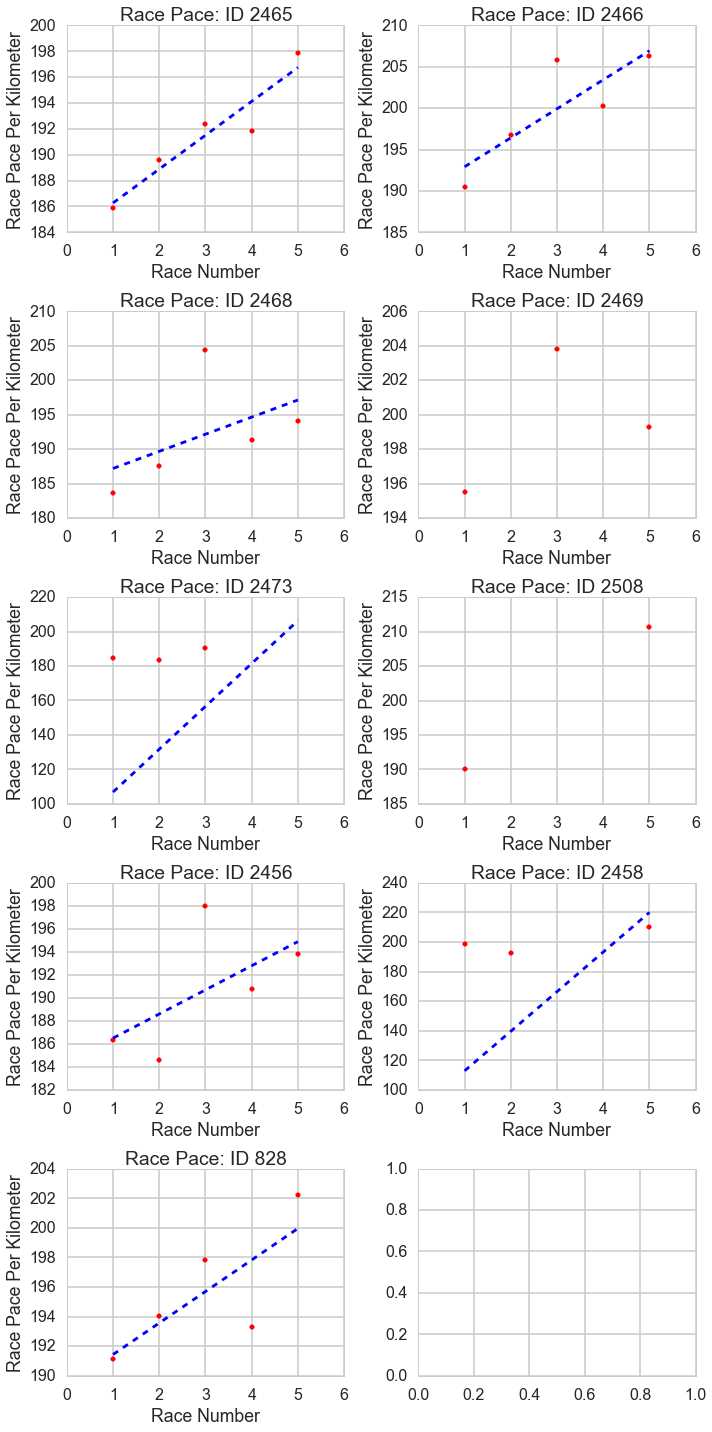

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20), tight_layout=True)
for ax, user in zip(axes.ravel(),users):
    person = df_pre[df_pre['user_id']==user]
    ax.scatter(person.race_period, person.pace_per_k, color="red")
    ax.plot(person.race_period, np.poly1d(np.polyfit(person.race_period, person.pace_per_k, 1))(person.race_period), '--b')
    ax.set_title('Race Pace: ID '+(str(user)))
    ax.set_ylabel('Race Pace Per Kilometer')
    ax.set_xlabel('Race Number')

In [23]:
#test=df_2458.pace_per_k
#print np.where(~np.isnan(test))

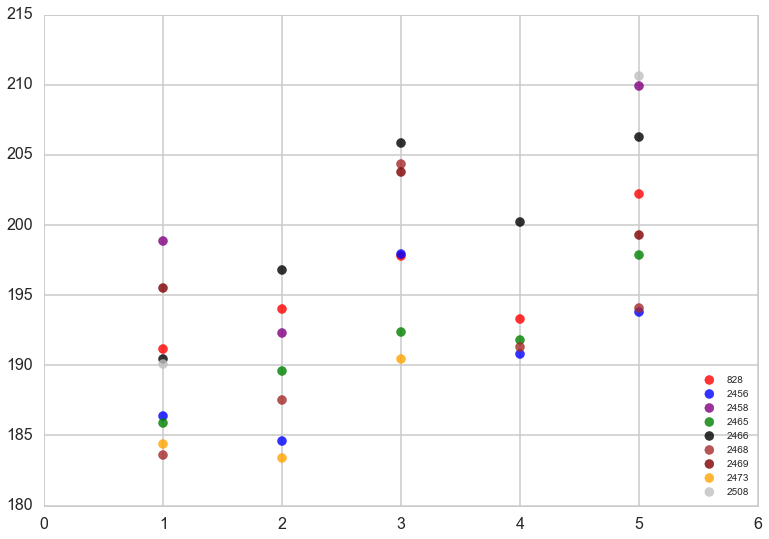

In [24]:
df_828 = df_pre[df_pre['user_id']==828]
df_2508 = df_pre[df_pre['user_id']==2508]
df_2458 = df_pre[df_pre['user_id']==2458]
df_2456 = df_pre[df_pre['user_id']==2456]
df_2469 = df_pre[df_pre['user_id']==2469]
df_2465 = df_pre[df_pre['user_id']==2465]
df_2466 = df_pre[df_pre['user_id']==2466]
df_2468 = df_pre[df_pre['user_id']==2468]
df_2473 = df_pre[df_pre['user_id']==2473]
plt1 = plt.scatter(df_828.race_period, df_828.pace_per_k, color='r', s=80, alpha=0.8)
plt2 = plt.scatter(df_2456.race_period, df_2456.pace_per_k, color='blue', s=80, alpha=0.8)
plt3 = plt.scatter(df_2458.race_period, df_2458.pace_per_k, color='purple', s=80, alpha=0.8)
plt4 = plt.scatter(df_2465.race_period, df_2465.pace_per_k, color='green', s=80, alpha=0.8)
plt5 = plt.scatter(df_2466.race_period, df_2466.pace_per_k, color='black', s=80, alpha=0.8)
plt6 = plt.scatter(df_2468.race_period, df_2468.pace_per_k, color='brown', s=80, alpha=0.8)
plt7 = plt.scatter(df_2469.race_period, df_2469.pace_per_k, color='maroon', s=80, alpha=0.8)
plt8 = plt.scatter(df_2473.race_period, df_2473.pace_per_k, color='orange', s=80, alpha=0.8)
plt9 = plt.scatter(df_2508.race_period, df_2508.pace_per_k, color='silver', s=80, alpha=0.8)

#m, b = np.polyfit(df_828.race_period, df_828.pace_per_k, 1)
#plt.plot(df_828.race_period, m*(df_828.race_period) + b, '--', color='red', alpha=0.6)
#m, b = np.polyfit(df_2456.race_period, df_2456.pace_per_k, 1)
#plt.plot(df_2456.race_period, m*(df_2456.race_period) + b, '--', color='blue', alpha=0.6)
#m, b = np.polyfit(df_2458.race_period, df_2458.pace_per_k, 1)
#plt.plot(df_2458.race_period, m*(np.where(~np.isnan(df_2458.race_period))) + b, '--', color='purple', alpha=0.6)

#plt.plot(df_828.race_period, np.poly1d(np.polyfit(df_828.race_period, df_828.pace_per_k, 1))(df_828.race_period), 'r', ls='--', alpha=0.6)
#plt.plot(df_2456.race_period, np.poly1d(np.polyfit(df_2456.race_period, df_2456.pace_per_k, 1))(df_2456.race_period), 'blue', ls='--', alpha=0.6)
#plt.plot(df_2458.race_period, np.poly1d(np.polyfit(df_2458.race_period, df_2458.pace_per_k, 1))(df_2458.race_period), 'purple', ls='--', alpha=0.6)
#plt.plot(df_2465.race_period, np.poly1d(np.polyfit(df_2465.race_period, df_2465.pace_per_k, 1))(df_2465.race_period), 'green', ls='--', alpha=0.6)
#plt.plot(df_2466.race_period, np.poly1d(np.polyfit(df_2466.race_period, df_2466.pace_per_k, 1))(df_2466.race_period), 'black', ls='--', alpha=0.6)
#plt.plot(df_2468.race_period, np.poly1d(np.polyfit(df_2468.race_period, df_2468.pace_per_k, 1))(df_2468.race_period), 'brown', ls='--', alpha=0.6)
#plt.plot(df_2469.race_period, np.poly1d(np.polyfit(df_2469.race_period, df_2469.pace_per_k, 1))(df_2469.race_period), 'maroon', ls='--', alpha=0.6)
#plt.plot(df_2473.race_period, np.poly1d(np.polyfit(df_2473.race_period, df_2473.pace_per_k, 1))(df_2473.race_period), 'orange', ls='--', alpha=0.6)
#plt.plot(df_2508.race_period, np.poly1d(np.polyfit(df_2508.race_period, df_2508.pace_per_k, 1))(df_2508.race_period), 'silver', ls='--', alpha=0.6)
plt.legend((plt1, plt2, plt3, plt4, plt5, plt6, plt7, plt8, plt9), ('828', '2456', '2458', '2465', '2466', '2468', '2469', '2473', '2508'),
    loc = 'lower right' , fontsize = 10
)
#plt.xlim(0.8, 5.2)
#plt.ylim(180, 220)

In [25]:
#plt1 = plt.scatter(df_828.race_period, df_828.pace_per_k, color='r', s=80, alpha=0.8)
#plt2 = plt.scatter(df_2456.race_period, df_2456.pace_per_k, color='blue', s=80, alpha=0.8)
#plt3 = plt.scatter(df_2458.race_period, df_2458.pace_per_k, color='purple', s=80, alpha=0.8)
#plt4 = plt.scatter(df_2465.race_period, df_2465.pace_per_k, color='green', s=80, alpha=0.8)
#plt5 = plt.scatter(df_2466.race_period, df_2466.pace_per_k, color='black', s=80, alpha=0.8)
#plt6 = plt.scatter(df_2468.race_period, df_2468.pace_per_k, color='brown', s=80, alpha=0.8)
#plt7 = plt.scatter(df_2469.race_period, df_2469.pace_per_k, color='maroon', s=80, alpha=0.8)
#plt8 = plt.scatter(df_2473.race_period, df_2473.pace_per_k, color='orange', s=80, alpha=0.8)
#plt9 = plt.scatter(df_2508.race_period, df_2508.pace_per_k, color='silver', s=80, alpha=0.8)

#Original Regressions, with new units and mean-centered

####The Functions We Need From Previous Notebooks

In [26]:
def mixed_effects_model(dftouse, env, y_var, x_var, group_vars=None, vary_slope=False):
    env = env
    if group_vars == None:
        print 'Not a mixed effects model!'
        return 'Not a mixed effects model!'
    for varname in r.colnames(dftouse):
        env[varname] = dftouse.rx2(varname)
    if type(group_vars) == str:
        if vary_slope == True:
            formula = Formula(y_var + ' ~ ' + x_var + ' + (1+' + x_var + '|' + group_vars + ')', environment = env)
            #print formula
            model = lmerTest.lmer(formula)
            return model
        else:
            formula = Formula(y_var + ' ~ ' + x_var + ' + (1|' + group_vars + ')', environment = env)
            model = lmerTest.lmer(formula)
            return r.summary(model)
    elif type(group_vars)== tuple or type(group_vars)== list:
        if len(group_vars) == 2:
            formula = Formula(y_var + ' ~ ' + x_var + ' + (1|' + group_vars[0] + ') + (1|' + group_vars[1] + ')', environment=env)
            model = lmerTest.lmer(formula)
            return r.summary(model)
        elif len(group_vars) == 3:
            formula =Formula(y_var + ' ~ ' + x_var + ' + (1|' + group_vars[0] + ' ' + group_vars[1] + ' ' + group_vars[2]+ ')', 
                             environment = env)
            model = lmerTest.lmer(formula)
            return r.summary(model)
    

In [27]:
df.to_csv('df.csv')
pace_df_only.to_csv('pace_df_only.csv')
final_df.to_csv('final_df.csv')

These allow for only the intercepts to vary

##Varying Intercept Only
####For Races
- REM sleep, runner mixed effects, two nights before the race: significant for both Bonferroni and Permutation Correction
- REM sleep, runner mixed effects, weighted two days: significant for Bonferroni only
- REM sleep, runner mixed effects, weighted three days: significant for Bonferroni only
- Total sleep, runner mixed effects, weighted three days: significant for Bonerroni only
- REM sleep, runner mixed effects, weighted four days: significant for Bonerroni only
- REM sleep, runner mixed effects, expo weighted 2 days: significant for both Bonferroni and Permutation Correction

([array([ 1.,  2.,  4.,  4.,  6.,  5.,  5.,  3.,  1.,  1.]),
  array([  1.,   0.,   4.,   4.,  10.,   6.,   5.,   0.,   1.,   1.])],
 array([-2.15387469, -1.70611447, -1.25835425, -0.81059403, -0.36283381,
         0.08492641,  0.53268663,  0.98044685,  1.42820707,  1.87596729,
         2.32372751]),
 <a list of 2 Lists of Patches objects>)

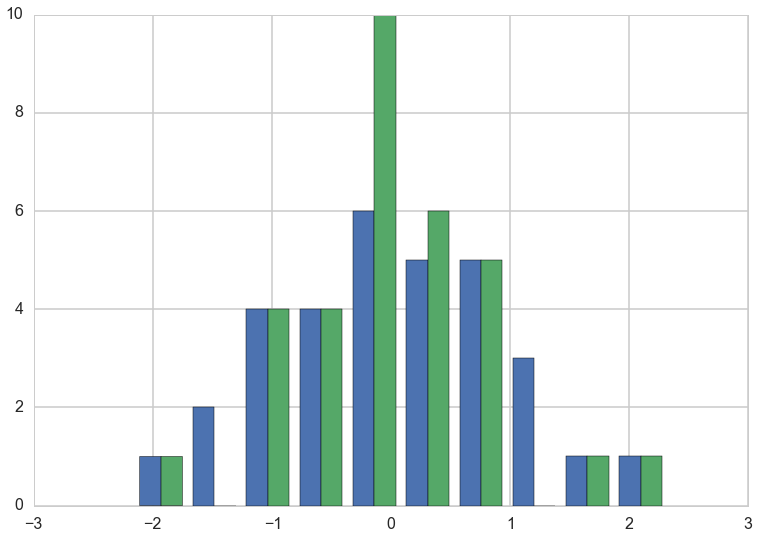

In [33]:
plt.hist(r.qqnorm(r.resid(fit1)))

In [31]:
def regression_assumptions(fit):
    #Normality of Residuals
    qq = r.qqPlot(fit, main="QQ Plot")
    sresid = r.studres(fit)
    histo = r.hist(sresid)
    

In [32]:
pandas2ri.activate()
r_df = pandas2ri.py2ri(df)
r_final_df = pandas2ri.py2ri(final_df)
r_pace_only_df = pandas2ri.py2ri(pace_df_only)
env=Environment()
fit1 = mixed_effects_model(r_df, env, y_var='pace_per_k', x_var='REM_2nd_Night_Before', group_vars='user_id')
fit2 = mixed_effects_model(r_df, env, y_var='pace_per_k', x_var='REM_Weighted_2_Days', group_vars='user_id')
fit3 = mixed_effects_model(r_df, env, y_var='pace_per_k', x_var='REM_Weighted_3_Days', group_vars='user_id')
fit4 = mixed_effects_model(r_df, env, y_var='pace_per_k', x_var='REM_Weighted_4_Days', group_vars='user_id')
fit5 = mixed_effects_model(r_df, env, y_var='pace_per_k', x_var='REM_Expo_Weighted_2_Days', group_vars='user_id')
fit6 = mixed_effects_model(r_df, env, y_var='pace_per_k', x_var='total_sleep_weighted_3days', group_vars='user_id')

In [34]:
print r.summary(fit1)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ REM_2nd_Night_Before + (1 | user_id)



REML criterion at convergence: 212.3



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-2.14898 -0.37920 -0.07446  0.48287  2.32373 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept) 44.41    6.664   

 Residual             25.28    5.028   

Number of obs: 32, groups:  user_id, 9



Fixed effects:

                      Estimate Std. Error        df t value Pr(>|t|)    

(Intercept)          200.01547    2.76709  11.16400   72.28 4.44e-16 ***

REM_2nd_Night_Before  -0.07101    0.01789  26.96700   -3.97  0.00048 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr)

REM_2nd_N_B -0.493



In [35]:
print r.summary(fit2)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ REM_Weighted_2_Days + (1 | user_id)



REML criterion at convergence: 225.6



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.83231 -0.50071 -0.00979  0.63740  2.07469 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept) 27.70    5.263   

 Residual             29.08    5.393   

Number of obs: 34, groups:  user_id, 9



Fixed effects:

                     Estimate Std. Error        df t value Pr(>|t|)    

(Intercept)         199.92381    2.53461  14.24000  78.878  < 2e-16 ***

REM_Weighted_2_Days  -0.05939    0.01801  31.65000  -3.297  0.00242 ** 

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr)

REM_Wgh_2_D -0.615



In [36]:
print r.summary(fit3)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ REM_Weighted_3_Days + (1 | user_id)



REML criterion at convergence: 232.9



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.7970 -0.5270 -0.0274  0.7267  2.0294 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept) 27.20    5.215   

 Residual             30.36    5.510   

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                     Estimate Std. Error        df t value Pr(>|t|)    

(Intercept)         200.08797    2.56021  14.17000  78.153  < 2e-16 ***

REM_Weighted_3_Days  -0.06020    0.01896  32.97000  -3.176  0.00323 ** 

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr)

REM_Wgh_3_D -0.630



In [37]:
print r.summary(fit4)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ REM_Weighted_4_Days + (1 | user_id)



REML criterion at convergence: 238.5



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.8318 -0.5106 -0.0566  0.7505  2.0574 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept) 27.85    5.278   

 Residual             29.29    5.412   

Number of obs: 36, groups:  user_id, 9



Fixed effects:

                     Estimate Std. Error        df t value Pr(>|t|)    

(Intercept)         200.13624    2.54676  14.16000  78.584  < 2e-16 ***

REM_Weighted_4_Days  -0.06183    0.01912  33.86000  -3.234  0.00272 ** 

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr)

REM_Wgh_4_D -0.622



In [38]:
print r.summary(fit5)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ REM_Expo_Weighted_2_Days + (1 | user_id)



REML criterion at convergence: 226.8



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.69573 -0.66995  0.02045  0.69862  2.00349 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept) 28.48    5.337   

 Residual             30.29    5.504   

Number of obs: 34, groups:  user_id, 9



Fixed effects:

                          Estimate Std. Error        df t value Pr(>|t|)    

(Intercept)              199.07742    2.47372  12.92600  80.477  < 2e-16 ***

REM_Expo_Weighted_2_Days  -0.05396    0.01778  31.47300  -3.036  0.00479 ** 

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr)

REM_E_W_2_D -0.572



In [39]:
print r.summary(fit6)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ total_sleep_weighted_3days + (1 | user_id)



REML criterion at convergence: 232.6



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.4718 -0.5290 -0.1689  0.7853  2.0527 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept) 31.09    5.576   

 Residual             29.65    5.446   

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                            Estimate Std. Error        df t value Pr(>|t|)    

(Intercept)                233.19754   12.03171  32.37000  19.382  < 2e-16 ***

total_sleep_weighted_3days  -0.08067    0.02501  31.62000  -3.226  0.00292 ** 

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr)

ttl_slp_w_3 -0.985



##Varying Slope and Intercept
- REM cycle count, runner mixed effects, two nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted two nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted three nights before the race: significant for Bonferroni
- REM cycle count, runner mixed effects, weighted three nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted four nights before the race: significant for Bonferroni
- REM cycle count, runner mixed effects, weighted four nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted five nights before the race: significant for Bonferroni
- sleep duration, runner mixed effects, weighted six nights before the race: significant for Bonferroni
- REM sleep duration, runner mixed effects, exponentially weighted two nights before the race, significant for Bonferroni
- REM sleep duration, runner mixed effects, exponentially weighted three nights before the race, singificant for Bonferroni
- REM sleep duration, runner mixed effects, exponentially weighted four nights before the race, significant for Bonferroni

In [40]:
def vary_slope_model_output(fit):
    print r.summary(fit)
    print '*************** user_id- Level Errors ***************'
    print r.ranef(fit)
    print '*************** estimated coefficients for each user_id ***************'
    print r.coef(fit)

In [41]:
fit7 = mixed_effects_model(r_final_df, env=env, y_var='pace_per_k', x_var = 'cycles_count_2nd_Night_Before', group_vars='user_id', vary_slope=True)
fit8 = mixed_effects_model(r_final_df, env=env, y_var='pace_per_k', x_var = 'cycles_count_weighted_3days', group_vars='user_id', vary_slope=True)
fit9 = mixed_effects_model(r_final_df, env=env, y_var='pace_per_k', x_var = 'cycles_count_weighted_4days', group_vars='user_id', vary_slope=True)
fit10 = mixed_effects_model(r_final_df, env, y_var='pace_per_k', x_var = 'total_sleep_weighted_2days', group_vars='user_id', vary_slope=True)
fit11 = mixed_effects_model(r_final_df, env, y_var='pace_per_k', x_var = 'total_sleep_weighted_3days', group_vars='user_id', vary_slope=True)
fit12 = mixed_effects_model(r_final_df, env, y_var='pace_per_k', x_var = 'total_sleep_weighted_4days', group_vars='user_id', vary_slope=True)
fit13 = mixed_effects_model(r_final_df, env, y_var='pace_per_k', x_var = 'total_sleep_weighted_5days', group_vars='user_id', vary_slope=True)
fit14 = mixed_effects_model(r_final_df, env, y_var='pace_per_k', x_var = 'total_sleep_weighted_6days', group_vars='user_id', vary_slope=True)
fit15 = mixed_effects_model(r_final_df, env, y_var='pace_per_k', x_var = 'REM_Expo_Weighted_2_Days', group_vars='user_id', vary_slope=True)
fit16 = mixed_effects_model(r_final_df, env, y_var='pace_per_k', x_var = 'REM_Expo_Weighted_3days', group_vars='user_id', vary_slope=True)
fit17 = mixed_effects_model(r_final_df, env, y_var='pace_per_k', x_var = 'REM_Expo_Weighted_4days', group_vars='user_id', vary_slope=True)

In [42]:
print vary_slope_model_output(fit7)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: 

pace_per_k ~ cycles_count_2nd_Night_Before + (1 + cycles_count_2nd_Night_Before |  

    user_id)



REML criterion at convergence: 191.1



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-2.54637 -0.75391  0.07211  0.39699  1.69815 



Random effects:

 Groups   Name                          Variance  Std.Dev.  Corr

 user_id  (Intercept)                   0.000e+00 0.000e+00     

          cycles_count_2nd_Night_Before 7.150e-15 8.456e-08  NaN

 Residual                               2.549e+01 5.048e+00     

Number of obs: 32, groups:  user_id, 9



Fixed effects:

                              Estimate Std. Error      df t value Pr(>|t|)   

(Intercept)                    -0.4067     0.8928 30.0000  -0.456   0.6520   

cycles_count_2nd_Night_Before  -1.1448     0.3453 30.0000  -3.316   0.0024 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*'

In [43]:
print vary_slope_model_output(fit8)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: 

pace_per_k ~ cycles_count_weighted_3days + (1 + cycles_count_weighted_3days |  

    user_id)



REML criterion at convergence: 209.6



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-2.38176 -0.52636 -0.02889  0.61401  1.83693 



Random effects:

 Groups   Name                        Variance  Std.Dev.  Corr

 user_id  (Intercept)                 0.000e+00 0.000e+00     

          cycles_count_weighted_3days 9.367e-20 3.061e-10  NaN

 Residual                             2.620e+01 5.119e+00     

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                            Estimate Std. Error       df t value Pr(>|t|)   

(Intercept)                 -0.06364    0.86521 33.00000  -0.074  0.94181   

cycles_count_weighted_3days -1.57451    0.50095 33.00000  -3.143  0.00352 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 '

In [44]:
print vary_slope_model_output(fit9)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: 

pace_per_k ~ cycles_count_weighted_4days + (1 + cycles_count_weighted_4days |  

    user_id)



REML criterion at convergence: 215.8



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-2.41155 -0.49820 -0.06633  0.61312  1.89586 



Random effects:

 Groups   Name                        Variance  Std.Dev.  Corr

 user_id  (Intercept)                 0.000e+00 0.000e+00     

          cycles_count_weighted_4days 3.416e-20 1.848e-10  NaN

 Residual                             2.635e+01 5.133e+00     

Number of obs: 36, groups:  user_id, 9



Fixed effects:

                            Estimate Std. Error       df t value Pr(>|t|)   

(Intercept)                 -0.02539    0.85562 34.00000  -0.030  0.97650   

cycles_count_weighted_4days -1.62243    0.54770 34.00000  -2.962  0.00554 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 '

In [45]:
print vary_slope_model_output(fit10)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: 

pace_per_k ~ total_sleep_weighted_2days + (1 + total_sleep_weighted_2days |  

    user_id)



REML criterion at convergence: 206.2



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.7202 -0.7372 -0.1126  0.5251  2.0955 



Random effects:

 Groups   Name                       Variance  Std.Dev.  Corr

 user_id  (Intercept)                0.000e+00 0.000e+00     

          total_sleep_weighted_2days 1.409e-14 1.187e-07  NaN

 Residual                            2.352e+01 4.850e+00     

Number of obs: 34, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error       df t value Pr(>|t|)    

(Intercept)                 0.07090    0.83620 32.00000   0.085 0.932959    

total_sleep_weighted_2days -0.08127    0.02182 32.00000  -3.724 0.000754 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlat

In [46]:
print vary_slope_model_output(fit11)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: 

pace_per_k ~ total_sleep_weighted_3days + (1 + total_sleep_weighted_3days |  

    user_id)



REML criterion at convergence: 211.9



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.7439 -0.6637 -0.1019  0.6483  2.1241 



Random effects:

 Groups   Name                       Variance  Std.Dev.  Corr

 user_id  (Intercept)                0.000e+00 0.000e+00     

          total_sleep_weighted_3days 6.904e-14 2.627e-07  NaN

 Residual                            2.339e+01 4.836e+00     

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error       df t value Pr(>|t|)    

(Intercept)                 0.27986    0.82201 33.00000   0.340 0.735670    

total_sleep_weighted_3days -0.08849    0.02282 33.00000  -3.877 0.000476 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlat

In [47]:
print vary_slope_model_output(fit12)

Linear mixed model fit by REML ['lmerMod']

Formula: 

pace_per_k ~ total_sleep_weighted_4days + (1 + total_sleep_weighted_4days |  

    user_id)



REML criterion at convergence: 219.6



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.7929 -0.6900 -0.1084  0.6372  2.5271 



Random effects:

 Groups   Name                       Variance  Std.Dev. Corr

 user_id  (Intercept)                0.000e+00 0.00000      

          total_sleep_weighted_4days 2.709e-04 0.01646   NaN

 Residual                            2.404e+01 4.90275      

Number of obs: 36, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error t value

(Intercept)                 0.16569    0.81951   0.202

total_sleep_weighted_4days -0.07328    0.02195  -3.338



Correlation of Fixed Effects:

            (Intr)

ttl_slp_w_4 -0.060

convergence code: 0

unable to evaluate scaled gradient

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues



******

In [48]:
print vary_slope_model_output(fit13)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: 

pace_per_k ~ total_sleep_weighted_5days + (1 + total_sleep_weighted_5days |  

    user_id)



REML criterion at convergence: 218.8



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.88994 -0.65292 -0.08383  0.58359  2.42785 



Random effects:

 Groups   Name                       Variance  Std.Dev.  Corr

 user_id  (Intercept)                0.000e+00 0.000e+00     

          total_sleep_weighted_5days 9.362e-17 9.676e-09  NaN

 Residual                            2.393e+01 4.891e+00     

Number of obs: 36, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error       df t value Pr(>|t|)    

(Intercept)                 0.17858    0.81672 34.00000   0.219 0.828222    

total_sleep_weighted_5days -0.08064    0.02227 34.00000  -3.621 0.000945 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



In [49]:
print vary_slope_model_output(fit14)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: 

pace_per_k ~ total_sleep_weighted_6days + (1 + total_sleep_weighted_6days |  

    user_id)



REML criterion at convergence: 217.7



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.9986 -0.5750 -0.1042  0.5085  2.4466 



Random effects:

 Groups   Name                       Variance  Std.Dev.  Corr

 user_id  (Intercept)                0.000e+00 0.000e+00     

          total_sleep_weighted_6days 9.253e-19 9.619e-10  NaN

 Residual                            2.314e+01 4.811e+00     

Number of obs: 36, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error       df t value Pr(>|t|)    

(Intercept)                 0.16273    0.80289 34.00000   0.203 0.840588    

total_sleep_weighted_6days -0.08249    0.02151 34.00000  -3.835 0.000518 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlat

In [50]:
print vary_slope_model_output(fit15)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: 

pace_per_k ~ REM_Expo_Weighted_2_Days + (1 + REM_Expo_Weighted_2_Days |  

    user_id)



REML criterion at convergence: 207.3



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-2.21348 -0.86296 -0.03763  0.71927  2.17109 



Random effects:

 Groups   Name                     Variance  Std.Dev.  Corr

 user_id  (Intercept)              0.000e+00 0.000e+00     

          REM_Expo_Weighted_2_Days 6.575e-17 8.109e-09  NaN

 Residual                          2.394e+01 4.893e+00     

Number of obs: 34, groups:  user_id, 9



Fixed effects:

                          Estimate Std. Error        df t value Pr(>|t|)   

(Intercept)               0.006309   0.842107 32.000000   0.007  0.99407   

REM_Expo_Weighted_2_Days -0.060759   0.016806 32.000000  -3.615  0.00102 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation o

In [51]:
print vary_slope_model_output(fit16)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ REM_Expo_Weighted_3days + (1 + REM_Expo_Weighted_3days |  

    user_id)



REML criterion at convergence: 217.1



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-2.1228 -0.6644 -0.1403  0.8125  2.0952 



Random effects:

 Groups   Name                    Variance  Std.Dev.  Corr

 user_id  (Intercept)             0.000e+00 0.000e+00     

          REM_Expo_Weighted_3days 2.676e-19 5.173e-10  NaN

 Residual                         2.713e+01 5.209e+00     

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                        Estimate Std. Error       df t value Pr(>|t|)   

(Intercept)              0.24403    0.88651 33.00000   0.275  0.78483   

REM_Expo_Weighted_3days -0.06261    0.02160 33.00000  -2.899  0.00661 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

         

In [52]:
print vary_slope_model_output(fit17)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ REM_Expo_Weighted_4days + (1 + REM_Expo_Weighted_4days |  

    user_id)



REML criterion at convergence: 220.8



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-2.1957 -0.6866 -0.0624  0.7120  1.9439 



Random effects:

 Groups   Name                    Variance  Std.Dev.  Corr

 user_id  (Intercept)             0.000e+00 0.000e+00     

          REM_Expo_Weighted_4days 6.967e-24 2.640e-12  NaN

 Residual                         2.514e+01 5.014e+00     

Number of obs: 36, groups:  user_id, 9



Fixed effects:

                        Estimate Std. Error       df t value Pr(>|t|)   

(Intercept)              0.21460    0.83814 34.00000   0.256  0.79946   

REM_Expo_Weighted_4days -0.06399    0.01943 34.00000  -3.293  0.00232 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

         

#From these, pick the most significant predictors for Multi-Variate Models

#Trying Multi-Variate Models

In [53]:
def multi_variate_model(dftouse, env, y_var, x_vars, group_vars=None, vary_slope=True):
    if group_vars==None:
        return 'Not a mixed effects model!'
    if type(x_vars) != list:
        return 'Send a list of X variables'
    env=env
    for varname in r.colnames(dftouse):
        env[varname] = dftouse.rx2(varname)
    
    
    formula_string = y_var + ' ~ '
    
    if vary_slope == False:
        for x in x_vars:
            formula_string = formula_string + ' + ' + x
        
        formula_string += ' + (1|' + group_vars + ')'
        
    if vary_slope == True:
        end_string = ''
        for x in x_vars:
            formula_string = formula_string + ' + ' + x
        
            end_string = end_string + ' + (1 + ' + x + '|' + group_vars + ')'
        formula_string = formula_string + end_string
            
    formula = Formula(formula_string, environment=env)
    fit = lmerTest.lmer(formula)
    return fit

In [54]:
env = Environment()
xlist = ['REM_Weighted_3_Days', 'total_sleep_weighted_3days']
m_fit1 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit1_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit1)
print '*******************************************************************************************************'
print r.summary(m_fit1_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_Weighted_3_Days + total_sleep_weighted_3days +  

    (1 | user_id)



REML criterion at convergence: 212.3



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.4743 -0.7140 -0.1124  0.8258  1.9463 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.000   

 Residual             20.23    4.497   

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error       df t value Pr(>|t|)   

(Intercept)                 0.40808    0.76617 32.00000   0.533  0.59797   

REM_Weighted_3_Days        -0.04502    0.01814 32.00000  -2.482  0.01851 * 

total_sleep_weighted_3days -0.06429    0.02336 32.00000  -2.752  0.00966 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr) REM_W_

REM_Wgh_3_D -

In [55]:
#adding in stress
env=Environment()
xlist = ['REM_Weighted_3_Days', 'total_sleep_weighted_3days', 'stress_during_week', 'schoolwork_hours_during_week']
m_fit2 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit2_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit2)
print '*******************************************************************************************************'
print r.summary(m_fit2_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_Weighted_3_Days + total_sleep_weighted_3days +  

    stress_during_week + schoolwork_hours_during_week + (1 |      user_id)



REML criterion at convergence: 118.9



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.93742 -0.43379  0.05747  0.46920  2.03743 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.000   

 Residual             17.31    4.161   

Number of obs: 20, groups:  user_id, 9



Fixed effects:

                             Estimate Std. Error       df t value Pr(>|t|)  

(Intercept)                  -2.28265    2.75060 15.00000  -0.830   0.4196  

REM_Weighted_3_Days          -0.05318    0.02393 15.00000  -2.222   0.0421 *

total_sleep_weighted_3days   -0.04319    0.02719 15.00000  -1.588   0.1331  

stress_during_week            1.33417    0.96132 15.00000   1.388   0.1

In [56]:
#adding in stress
env=Environment()
xlist = ['REM_Weighted_3_Days', 'total_sleep_weighted_3days', 'stress_during_week_2', 'schoolwork_hours_during_week']
m_fit3 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit3_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit3)
print '*******************************************************************************************************'
print r.summary(m_fit3_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_Weighted_3_Days + total_sleep_weighted_3days +  

    stress_during_week_2 + schoolwork_hours_during_week + (1 |      user_id)



REML criterion at convergence: 121.2



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.61170 -0.61176 -0.08331  0.66199  1.86858 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.000   

 Residual             19.42    4.407   

Number of obs: 20, groups:  user_id, 9



Fixed effects:

                              Estimate Std. Error        df t value Pr(>|t|)  

(Intercept)                   0.292199   2.321550 15.000000   0.126   0.9015  

REM_Weighted_3_Days          -0.056160   0.025771 15.000000  -2.179   0.0457 *

total_sleep_weighted_3days   -0.043484   0.028827 15.000000  -1.508   0.1522  

stress_during_week_2          0.231362   0.765730 15.000000  

In [57]:
env=Environment()
xlist = ['REM_2nd_Night_Before', 'total_sleep_weighted_2days', 'stress_during_week_2', 'schoolwork_hours_during_week']
m_fit4 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit4_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit4)
print '*******************************************************************************************************'
print r.summary(m_fit4_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_2nd_Night_Before + total_sleep_weighted_2days +  

    stress_during_week_2 + schoolwork_hours_during_week + (1 |      user_id)



REML criterion at convergence: 113.6



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.43073 -0.79367  0.00195  0.59548  1.61120 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.000   

 Residual             17.17    4.144   

Number of obs: 19, groups:  user_id, 9



Fixed effects:

                             Estimate Std. Error       df t value Pr(>|t|)  

(Intercept)                   0.71414    2.20203 14.00000   0.324   0.7505  

REM_2nd_Night_Before         -0.05941    0.02330 14.00000  -2.549   0.0232 *

total_sleep_weighted_2days   -0.04578    0.02677 14.00000  -1.710   0.1093  

stress_during_week_2         -0.38680    0.79632 14.00000  -0.486   

In [58]:
env=Environment()
xlist = ['REM_2nd_Night_Before', 'total_sleep_weighted_3days', 'stress_during_week_2', 'schoolwork_hours_during_week']
m_fit5 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit5_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit5)
print '*******************************************************************************************************'
print r.summary(m_fit5_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_2nd_Night_Before + total_sleep_weighted_3days +  

    stress_during_week_2 + schoolwork_hours_during_week + (1 |      user_id)



REML criterion at convergence: 113.2



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.5089 -0.7742  0.0784  0.5913  1.6382 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.000   

 Residual             16.76    4.094   

Number of obs: 19, groups:  user_id, 9



Fixed effects:

                             Estimate Std. Error       df t value Pr(>|t|)  

(Intercept)                   0.81004    2.18127 14.00000   0.371   0.7159  

REM_2nd_Night_Before         -0.06160    0.02244 14.00000  -2.745   0.0158 *

total_sleep_weighted_3days   -0.05041    0.02761 14.00000  -1.826   0.0892 .

stress_during_week_2         -0.38422    0.78608 14.00000  -0.489   0.6326  



In [59]:
env=Environment()
xlist = ['REM_2nd_Night_Before', 'total_sleep_weighted_4days', 'stress_during_week_2', 'schoolwork_hours_during_week']
m_fit6 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit6_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit6)
print '*******************************************************************************************************'
print r.summary(m_fit6_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_2nd_Night_Before + total_sleep_weighted_4days +  

    stress_during_week_2 + schoolwork_hours_during_week + (1 |      user_id)



REML criterion at convergence: 113.2



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.29789 -0.73035  0.04104  0.56587  1.88341 



Random effects:

 Groups   Name        Variance  Std.Dev.

 user_id  (Intercept) 1.393e-16 1.18e-08

 Residual             1.665e+01 4.08e+00

Number of obs: 19, groups:  user_id, 9



Fixed effects:

                             Estimate Std. Error       df t value Pr(>|t|)  

(Intercept)                   0.96588    2.18801 14.00000   0.441   0.6656  

REM_2nd_Night_Before         -0.06382    0.02199 14.00000  -2.903   0.0116 *

total_sleep_weighted_4days   -0.04926    0.02651 14.00000  -1.858   0.0843 .

stress_during_week_2         -0.24599    0.77857 14.00000  -0.316

In [60]:
env=Environment()
xlist = ['REM_Expo_Weighted_3days', 'total_sleep_weighted_3days']
m_fit7 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit7_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit7)
print '*******************************************************************************************************'
print r.summary(m_fit7_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_Expo_Weighted_3days + total_sleep_weighted_3days +  

    (1 | user_id)



REML criterion at convergence: 215.3



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.5905 -0.7078 -0.1115  0.7918  2.1006 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.000   

 Residual             22.39    4.732   

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error       df t value Pr(>|t|)   

(Intercept)                 0.37780    0.80666 32.00000   0.468  0.64271   

REM_Expo_Weighted_3days    -0.03457    0.02198 32.00000  -1.573  0.12562   

total_sleep_weighted_3days -0.07074    0.02502 32.00000  -2.827  0.00803 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr) REM_E_

REM_Exp_W

In [61]:
env=Environment()
xlist = ['REM_Expo_Weighted_3days', 'total_sleep_weighted_4days']
m_fit8 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit8_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit8)
print '*******************************************************************************************************'
print r.summary(m_fit8_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_Expo_Weighted_3days + total_sleep_weighted_4days +  

    (1 | user_id)



REML criterion at convergence: 215.2



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.7900 -0.7375 -0.1249  0.6841  2.4206 



Random effects:

 Groups   Name        Variance  Std.Dev. 

 user_id  (Intercept) 1.623e-14 1.274e-07

 Residual             2.225e+01 4.717e+00

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error       df t value Pr(>|t|)   

(Intercept)                 0.49024    0.80735 32.00000   0.607   0.5480   

REM_Expo_Weighted_3days    -0.04026    0.02105 32.00000  -1.912   0.0648 . 

total_sleep_weighted_4days -0.06831    0.02379 32.00000  -2.871   0.0072 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr) REM_E_

REM

In [62]:
env=Environment()
xlist = ['REM_2nd_Night_Before', 'total_sleep_weighted_4days']
m_fit9 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit9_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit9)
print '*******************************************************************************************************'
print r.summary(m_fit9_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_2nd_Night_Before + total_sleep_weighted_4days +  

    (1 | user_id)



REML criterion at convergence: 189.9



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.87041 -0.63887 -0.03505  0.82551  2.12587 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.000   

 Residual             17.09    4.134   

Number of obs: 32, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error       df t value Pr(>|t|)    

(Intercept)                 0.25665    0.74794 29.00000   0.343 0.733969    

REM_2nd_Night_Before       -0.06088    0.01540 29.00000  -3.954 0.000453 ***

total_sleep_weighted_4days -0.05751    0.02088 29.00000  -2.754 0.010056 *  

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr) REM_2_

In [63]:
env=Environment()
xlist = ['REM_2nd_Night_Before', 'total_sleep_weighted_3days']
m_fit10 = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
m_fit10_slope = multi_variate_model(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(m_fit10)
print '*******************************************************************************************************'
print r.summary(m_fit10_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_2nd_Night_Before + total_sleep_weighted_3days +  

    (1 | user_id)



REML criterion at convergence: 189.1



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.71801 -0.69696  0.07533  0.85457  1.88380 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.000   

 Residual             16.64    4.079   

Number of obs: 32, groups:  user_id, 9



Fixed effects:

                           Estimate Std. Error       df t value Pr(>|t|)   

(Intercept)                 0.11131    0.72945 29.00000   0.153  0.87978   

REM_2nd_Night_Before       -0.05675    0.01558 29.00000  -3.643  0.00105 **

total_sleep_weighted_3days -0.06320    0.02158 29.00000  -2.929  0.00656 **

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Correlation of Fixed Effects:

            (Intr) REM_2_

RE

#Interactions

In [64]:
def multi_variate_model_interactions(dftouse, env, y_var, x_vars, group_vars=None, vary_slope=True):
    if group_vars==None:
        return 'Not a mixed effects model!'
    if type(x_vars) != list:
        return 'Send a list of X variables'
    env=env
    for varname in r.colnames(dftouse):
        env[varname] = dftouse.rx2(varname)
    
    interaction_string = ' + '
    formula_string = y_var + ' ~ '
    
    if vary_slope == False:
        i = 0
        for x in x_vars:
            formula_string = formula_string + ' + ' + x 
            if i == 0:
                interaction_string = interaction_string + x + ':'
            else:
                interaction_string = interaction_string + x
            i = i + 1
            
        formula_string = formula_string + ' ' + interaction_string + ' + (1|' + group_vars + ')'
        
    if vary_slope == True:
        i = 0
        end_string = ''
        for x in x_vars:
            formula_string = formula_string + ' + ' + x
            if i == 0:
                interaction_string = interaction_string + x + ':'
            else:
                interaction_string = interaction_string + x
            i = i + 1
            end_string = end_string + ' + (1 + ' + x + '|' + group_vars + ')'
        formula_string = formula_string + ' ' + interaction_string + end_string
    
    formula = Formula(formula_string, environment=env)
    fit = lmerTest.lmer(formula)
    return fit

- REM 3 days 0.01 /totalsleep3days 0.009 -> vary intercept
- REM 3 days 0.08/totalsleep3days 0.08 -> vary slope
- REM 3 days 0.04, totalsleep3days/stress -> vary intercept
- Above regression had none sign. for vary slope
- Same above but stress_2
- REM Expo weight 3 days/total sleep 3 days 0.008 -> vary intercept
- REM Expo Weight 3 days/total sleep 3 days -> vary slope
- REM Expo Weight 3 days 0.007/total sleep 4 days -> vary intercept
- REM Expo Weight 3 days /total sleep 4 days -> vary slope
- REM 2nd Night Before/0.02, total sleep 2 day/stress -> vary intercept
- REM 2nd Night Before/0.008, total sleep 2days/stress -> vary slope
- REM 2nd Night Before/0.01,total sleep 3 days/stress -> vary intercept
- REM 2nd night before/0.007, total sleep 3days/stress -> vary slope
- REM 2nd Night Before/0.01, total sleep 4 days/stress -> vary intercept
- REM 2nd Night Before/0.005, total sleep 4 days/stress -> vary slope
- REM 2nd Night Before/0.0004, total sleep 4 0.01 -> vary intercept
- REM 2nd Night Before/0.007, total sleep 4 days -> vary slope
- REM 2nd Night Before/0.001, total sleep 3 days 0.006 -> vary intercept
- REM 2nd Night Before/0.008, total sleep 3 days -> vary slope

In [65]:
env=Environment()
xlist = ['REM_Weighted_3_Days', 'total_sleep_weighted_3days']
int_fit1 = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
int_fit1_slope = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(int_fit1)
print '*******************************************************************************************************'
print r.summary(int_fit1_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_Weighted_3_Days + total_sleep_weighted_3days +  

    REM_Weighted_3_Days:total_sleep_weighted_3days + (1 | user_id)



REML criterion at convergence: 215



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.2160 -0.7765 -0.2238  0.8144  1.9162 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.0     

 Residual             15.21    3.9     

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                                                 Estimate Std. Error         df

(Intercept)                                    -1.0266358  0.7870454 31.0000000

REM_Weighted_3_Days                            -0.0928207  0.0210967 31.0000000

total_sleep_weighted_3days                     -0.0547346  0.0204478 31.0000000

REM_Weighted_3_Days:total_sleep_weighted_3days  0.0023044  0.0006778 31.0000000

In [66]:
env=Environment()
xlist = ['REM_Expo_Weighted_3days', 'total_sleep_weighted_3days']
int_fit2 = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
int_fit2_slope = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(int_fit2)
print '*******************************************************************************************************'
print r.summary(int_fit2_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_Expo_Weighted_3days + total_sleep_weighted_3days +  

    REM_Expo_Weighted_3days:total_sleep_weighted_3days + (1 |      user_id)



REML criterion at convergence: 223.6



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.7695 -0.6651 -0.1165  0.5602  2.2049 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.0     0.000   

 Residual             20.3     4.505   

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                                                     Estimate Std. Error

(Intercept)                                        -0.6075299  0.9033145

REM_Expo_Weighted_3days                            -0.0648076  0.0255132

total_sleep_weighted_3days                         -0.0709876  0.0238238

REM_Expo_Weighted_3days:total_sleep_weighted_3days  0.0016709  0.0008062

                  

In [67]:
env=Environment()
xlist = ['REM_2nd_Night_Before', 'total_sleep_weighted_3days']
int_fit3 = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
int_fit3_slope = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(int_fit3)
print '*******************************************************************************************************'
print r.summary(int_fit3_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_2nd_Night_Before + total_sleep_weighted_3days +  

    REM_2nd_Night_Before:total_sleep_weighted_3days + (1 | user_id)



REML criterion at convergence: 195.2



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.62281 -0.94049 -0.04737  0.70864  1.69936 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.0     0.000   

 Residual             13.7     3.701   

Number of obs: 32, groups:  user_id, 9



Fixed effects:

                                                  Estimate Std. Error

(Intercept)                                     -1.0123783  0.7827584

REM_2nd_Night_Before                            -0.0849974  0.0176127

total_sleep_weighted_3days                      -0.0472485  0.0204562

REM_2nd_Night_Before:total_sleep_weighted_3days  0.0017924  0.0006667

                                  

In [68]:
env=Environment()
xlist = ['REM_2nd_Night_Before', 'total_sleep_weighted_4days']
int_fit4 = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
int_fit4_slope = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(int_fit4)
print '*******************************************************************************************************'
print r.summary(int_fit4_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_2nd_Night_Before + total_sleep_weighted_4days +  

    REM_2nd_Night_Before:total_sleep_weighted_4days + (1 | user_id)



REML criterion at convergence: 198



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.32321 -0.81558  0.00364  0.70166  2.26260 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.00    

 Residual             15.14    3.89    

Number of obs: 32, groups:  user_id, 9



Fixed effects:

                                                  Estimate Std. Error

(Intercept)                                     -0.6123190  0.8090718

REM_2nd_Night_Before                            -0.0840499  0.0179755

total_sleep_weighted_4days                      -0.0470214  0.0202339

REM_2nd_Night_Before:total_sleep_weighted_4days  0.0016129  0.0007405

                                    

In [69]:
env=Environment()
xlist = ['REM_Expo_Weighted_3days', 'total_sleep_weighted_4days']
int_fit5 = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = False)
int_fit5_slope = multi_variate_model_interactions(r_final_df, env, 'pace_per_k', x_vars=xlist, group_vars='user_id', vary_slope = True)
print r.summary(int_fit5)
print '*******************************************************************************************************'
print r.summary(int_fit5_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_Expo_Weighted_3days + total_sleep_weighted_4days +  

    REM_Expo_Weighted_3days:total_sleep_weighted_4days + (1 |      user_id)



REML criterion at convergence: 225



Scaled residuals: 

     Min       1Q   Median       3Q      Max 

-1.80445 -0.71348 -0.04249  0.73118  2.56349 



Random effects:

 Groups   Name        Variance Std.Dev.

 user_id  (Intercept)  0.00    0.000   

 Residual             21.03    4.586   

Number of obs: 35, groups:  user_id, 9



Fixed effects:

                                                     Estimate Std. Error

(Intercept)                                        -0.0831054  0.8550648

REM_Expo_Weighted_3days                            -0.0626294  0.0243725

total_sleep_weighted_4days                         -0.0708997  0.0231811

REM_Expo_Weighted_3days:total_sleep_weighted_4days  0.0012201  0.0007219

          

#Correlations

In [70]:
final_df.columns

Index([u'user_id', u'race_period', u'race_course', u'seconds', u'pace_time', u'Brown_8K', u'stress_during_week', u'schoolwork_hours_during_week', u'stress_during_week_2', u'REM_2nd_Night_Before', u'cycles_count_weighted_3days', u'cycles_count_weighted_4days', u'cycles_count_2nd_Night_Before', u'REM_Weighted_2_Days', u'REM_Weighted_3_Days', u'REM_Weighted_4_Days', u'REM_Expo_Weighted_2_Days', u'REM_Expo_Weighted_3days', u'REM_Expo_Weighted_4days', u'total_sleep_weighted_2days',
       u'total_sleep_weighted_3days', u'total_sleep_weighted_4days', u'total_sleep_weighted_5days', u'total_sleep_weighted_6days', u'pace_per_k'],
      dtype='object')

In [71]:
corr_df = final_df[['REM_2nd_Night_Before', 'cycles_count_weighted_3days', 'cycles_count_weighted_4days', 
                           'cycles_count_2nd_Night_Before', 'REM_Weighted_2_Days', 'REM_Weighted_3_Days', 
                            'REM_Weighted_4_Days', 'REM_Expo_Weighted_2_Days', 'REM_Expo_Weighted_3days',
                           'REM_Expo_Weighted_4days', 'total_sleep_weighted_2days', 'total_sleep_weighted_3days', 
                           'total_sleep_weighted_4days', 'total_sleep_weighted_5days', 'total_sleep_weighted_6days',
                   'stress_during_week_2', 'schoolwork_hours_during_week']]
corr_df.corr()

,REM_2nd_Night_Before,cycles_count_weighted_3days,cycles_count_weighted_4days,cycles_count_2nd_Night_Before,REM_Weighted_2_Days,REM_Weighted_3_Days,REM_Weighted_4_Days,REM_Expo_Weighted_2_Days,REM_Expo_Weighted_3days,REM_Expo_Weighted_4days,total_sleep_weighted_2days,total_sleep_weighted_3days,total_sleep_weighted_4days,total_sleep_weighted_5days,total_sleep_weighted_6days,stress_during_week_2,schoolwork_hours_during_week
REM_2nd_Night_Before,1.000000,0.714339,0.696932,0.799070,0.881253,0.873024,0.868579,0.865073,0.806326,0.806749,0.386080,0.324461,0.273702,0.289018,0.312428,-0.292911,-0.146926
cycles_count_weighted_3days,0.714339,1.000000,0.982469,0.799025,0.698252,0.678310,0.670507,0.714773,0.585483,0.590973,0.453643,0.393249,0.361991,0.369241,0.389376,-0.305288,-0.145263
cycles_count_weighted_4days,0.696932,0.982469,1.000000,0.800968,0.684198,0.670515,0.673171,0.706737,0.575516,0.609628,0.449629,0.386036,0.394707,0.394836,0.410343,-0.317301,-0.152182
cycles_count_2nd_Night_Before,0.799070,0.799025,0.800968,1.000000,0.659945,0.644582,0.637127,0.698836,0.558597,0.576622,0.421950,0.352131,0.317222,0.329925,0.340152,-0.346376,-0.029911
REM_Weighted_2_Days,0.881253,0.698252,0.684198,0.659945,1.000000,0.997014,0.990567,0.913743,0.929902,0.894283,0.538135,0.503874,0.442835,0.435678,0.437167,-0.253446,-0.204139
REM_Weighted_3_Days,0.873024,0.678310,0.670515,0.644582,0.997014,1.000000,0.995143,0.924494,0.953833,0.911010,0.552193,0.525916,0.462055,0.452571,0.450982,-0.259011,-0.213021
REM_Weighted_4_Days,0.868579,0.670507,0.673171,0.637127,0.990567,0.995143,1.000000,0.914561,0.956671,0.941687,0.535306,0.511364,0.475537,0.478745,0.479381,-0.274931,-0.225506
REM_Expo_Weighted_2_Days,0.865073,0.714773,0.706737,0.698836,0.913743,0.924494,0.914561,1.000000,0.920070,0.821994,0.617803,0.592649,0.520152,0.502990,0.498350,-0.313091,-0.099999
REM_Expo_Weighted_3days,0.806326,0.585483,0.575516,0.558597,0.929902,0.953833,0.956671,0.920070,1.000000,0.929557,0.571607,0.569153,0.500775,0.485370,0.472183,-0.253909,-0.203758
REM_Expo_Weighted_4days,0.806749,0.590973,0.609628,0.576622,0.894283,0.911010,0.941687,0.821994,0.929557,1.000000,0.438924,0.431986,0.447853,0.465587,0.467807,-0.294796,-0.220563


#Likelihood Ratio Test To Determine Best Models

- m_fit1 vs. int_fit1
- m_fit1_slope vs. int_fit1_slope
- m_fit7 vs. int_fit2
- m_fit7_slope vs. int_fit2_slope
- m_fit8 vs. int_fit5
- m_fit8_slope vs. int_fit5_slope
- m_fit9 vs. int_fit4
- m_fit9_slope vs. int_fit4_slope
- m_fit10 vs. int_fit3
- m_fit10_slope vs. int_fit3_slope

In [72]:
def LRT_model_comparison(model, interaction_model):
    x = r.anova(model, interaction_model, test="Chi")
    p_val = float(r.summary(x)[49][8:16])
    if p_val <= 0.05:
        return p_val, 'The intercept model is better'
    elif p_val > 0.05:
        return p_val, 'The non-intercept model is better'

In [73]:
LRT_model_comparison(m_fit1, int_fit1)

(0.000867, 'The intercept model is better')

In [74]:
LRT_model_comparison(m_fit1_slope, int_fit1_slope)

(0.001832, 'The intercept model is better')

In [75]:
LRT_model_comparison(m_fit7, int_fit2)

(0.03308, 'The intercept model is better')

In [76]:
LRT_model_comparison(m_fit7_slope, int_fit2_slope)

(0.03354, 'The intercept model is better')

In [77]:
LRT_model_comparison(m_fit8, int_fit5)

(0.07901, 'The non-intercept model is better')

In [78]:
LRT_model_comparison(m_fit8_slope, int_fit5_slope)

(0.07959, 'The non-intercept model is better')

In [79]:
LRT_model_comparison(m_fit9, int_fit4)

(0.02522, 'The intercept model is better')

In [80]:
LRT_model_comparison(m_fit9_slope, int_fit4_slope)

(0.02047, 'The intercept model is better')

In [81]:
LRT_model_comparison(m_fit10, int_fit3)

(0.006712, 'The intercept model is better')

In [82]:
LRT_model_comparison(m_fit10_slope, int_fit3_slope)

(0.002265, 'The intercept model is better')

- int_fit1
- int_fit1_slope
- int_fit2
- int_fit2_slope
- m_fit8
- m_fit8_slope
- int_fit4
- int_fit4_slope
- int_fit3
- int_fit3_slope

How to decide which of these models are the best? Try mean deviance below:

In [83]:
print 'Fit 1, interaction, intercept only: ', r.deviance(int_fit1)[0]
print 'Fit 1, interaction, slope and intercept: ', r.deviance(int_fit1_slope)[0]
print 'Fit 2, interaction, intercept only: ', r.deviance(int_fit2)[0]
print 'Fit 2, interaction, slope and intercept: ', r.deviance(int_fit2_slope)[0]
print 'Fit 8, no interaction, intercept only: ', r.deviance(m_fit8)[0]
print 'Fit 8, no interaction, slope and intercept: ', r.deviance(m_fit8_slope)[0]
print 'Fit 4, interaction, intercept only: ', r.deviance(int_fit4)[0]
print 'Fit 4, interaction, slope and intercept: ', r.deviance(int_fit4_slope)[0]
print 'Fit 3, intercept only: ', r.deviance(int_fit3)[0]
print 'Fit 3, slope and intercept: ', r.deviance(int_fit3_slope)[0]

Fit 1, interaction, intercept only:  214.95953913
Fit 1, interaction, slope and intercept:  214.944940012
Fit 2, interaction, intercept only:  223.569254523
Fit 2, interaction, slope and intercept:  223.529429643
Fit 8, no interaction, intercept only:  215.193582246
Fit 8, no interaction, slope and intercept:  215.044284184
Fit 4, interaction, intercept only:  197.984985142
Fit 4, interaction, slope and intercept:  194.268906315
Fit 3, intercept only:  195.204440926
Fit 3, slope and intercept:  191.127256634


In [84]:
print r.summary(int_fit3_slope)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to

  degrees of freedom [lmerMod]

Formula: pace_per_k ~ +REM_2nd_Night_Before + total_sleep_weighted_3days +  

    REM_2nd_Night_Before:total_sleep_weighted_3days + (1 + REM_2nd_Night_Before |  

    user_id) + (1 + total_sleep_weighted_3days | user_id)



REML criterion at convergence: 191.1



Scaled residuals: 

    Min      1Q  Median      3Q     Max 

-1.5542 -0.5317 -0.1638  0.4041  1.7910 



Random effects:

 Groups    Name                       Variance  Std.Dev.  Corr 

 user_id   (Intercept)                0.000e+00 0.000e+00      

           REM_2nd_Night_Before       2.924e-17 5.407e-09  NaN 

 user_id.1 (Intercept)                1.707e-01 4.132e-01      

           total_sleep_weighted_3days 3.505e-03 5.920e-02 -1.00

 Residual                             9.622e+00 3.102e+00      

Number of obs: 32, groups:  user_id, 9



Fixed effects:

                                                  Estimat

#Trying a Stepwise Model with all variables

In [148]:
def stepwise_model(dftouse, env, y_var, x_vars, group_vars=None):
    if group_vars==None:
        print 'Not a mixed effects model!'
        return 'Not a mixed effects model!'
    env=env
    for varname in r.colnames(dftouse):
        env[varname] = dftouse.rx2(varname)
    
    x_string= ' + '
    for i in range(0, len(xlist)):
        if i != (len(xlist)-1):
            x_string+= xlist[i] + ' + '
        else:
            x_string+= xlist[i] + ' '
    
    if type(group_vars) == str:
        formula = Formula(y_var + ' ~ ' + x_string + ' + (1|' + group_vars + ')', environment = env)
        fit = lmerTest.lmer(formula)
        return fit
    
    elif type(group_vars)== tuple or type(group_vars)== list:
        if len(group_vars) == 2:
            formula = Formula(y_var + ' ~ ' + x_string + ' + (1|' + group_vars[0] + ') + (1|' + group_vars[1] + ')', environment=env)
            fit = lmerTest.lmer(formula)
            return fit
        
        elif len(group_vars) == 3:
            formula =Formula(y_var + ' ~ ' + x_string + ' + (1|' + group_vars[0] + ' ' + group_vars[1] + ' ' + group_vars[2]+ ')', 
                             environment = env)
            fit = lmerTest.lmer(formula)
            return fit

In [152]:
final_df.columns

Index([u'user_id', u'race_period', u'race_course', u'seconds', u'pace_time', u'Brown_8K', u'stress_during_week', u'schoolwork_hours_during_week', u'stress_during_week_2', u'REM_2nd_Night_Before', u'cycles_count_weighted_3days', u'cycles_count_weighted_4days', u'cycles_count_2nd_Night_Before', u'REM_Weighted_2_Days', u'REM_Weighted_3_Days', u'REM_Weighted_4_Days', u'REM_Expo_Weighted_2_Days', u'REM_Expo_Weighted_3days', u'REM_Expo_Weighted_4days', u'total_sleep_weighted_2days',
       u'total_sleep_weighted_3days', u'total_sleep_weighted_4days', u'total_sleep_weighted_5days', u'total_sleep_weighted_6days', u'pace_per_k'],
      dtype='object')

In [156]:
env=Environment()
xlist = ['stress_during_week_2', 'user_id', 'race_period', 'race_course', 'seconds', 'pace_per_k', 'schoolwork_hours_during_week', 
        'REM_2nd_Night_Before', 'cycles_count_weighted_3days', 'cycles_count_weighted_4days', 'cycles_count_2nd_Night_Before',
        'REM_Weighted_2_Days', 'REM_Weighted_3_Days', 'REM_Weighted_4_Days', 'REM_Expo_Weighted_2_Days', 'REM_Expo_Weighted_3days',
        'REM_Expo_Weighted_4days', 'total_sleep_weighted_2days', 'total_sleep_weighted_3days', 'total_sleep_weighted_4days', 
        'total_sleep_weighted_5days' , 'total_sleep_weighted_6days']
for varname in r.colnames(r_final_df):
    env[varname] = r_final_df.rx2(varname)
x_string= ' + '
for i in range(0, len(xlist)):
    if i != (len(xlist)-1):
        x_string+= xlist[i] + ' + '
    else:
        x_string+= xlist[i] + ' '
formula = Formula('pace_per_k' + ' ~ ' + x_string + ' + (1|user_id)', environment = env)
fit = lmerTest.lmer(formula)
#stepwise_model = r.step(fit, direction='both')
print r.summary(fit)

RRuntimeError: Error in diag(vcov(object, use.hessian = use.hessian)) : 
  error in evaluating the argument 'x' in selecting a method for function 'diag': Error in asMethod(object) : not a positive definite matrix


However, this was leading to errors

In [43]:
env=Environment()
xlist = ['hrv_rmssd', 'resting_heart_rate', 'light_sleep_duration', 'rem_sleep_duration', 'slow_wave_sleep_duration',
'cycles_count', 'latency', 'z1', 'z2', 'z3', 'z4', 'z5']
for varname in r.colnames(reg_test):
    env[varname] = reg_test.rx2(varname)
x_string= ' + '
for i in range(0, len(xlist)):
    if i != (len(xlist)-1):
        x_string+= xlist[i] + ' + '
    else:
        x_string+= xlist[i] + ' '
formula = Formula('pace_per_k' + ' ~ ' + x_string + ' + (1|user_id)', environment = env)
fit = lmerTest.lmer(formula)
stepwise_model = r.step(fit, direction='both')

RRuntimeError: Error in solve.default(xtx[inds, inds]) : 
  system is computationally singular: reciprocal condition number = 5.51812e-19


In [20]:
xlist = ['hrv_rmssd', 'resting_heart_rate', 'light_sleep_duration', 'rem_sleep_duration', 'sleep_duration', 'slow_wave_sleep_duration',
'cycles_count', 'time_in_bed', 'latency', 'z1', 'z2', 'z3', 'z4', 'z5']

In [26]:
env=Environment()
fit = stepwise_model(reg_test, env, 'pace_per_k', xlist, group_vars='user_id')

RRuntimeError: Error: Dropping columns failed to produce full column rank design matrix
